In [1]:
# Manipulação de Dados
import pandas as pd
import numpy as np

# Visualização
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Métricas e Transformações
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.special import inv_boxcox
from scipy import stats

# Modelos e Ferramentas de Séries Temporais
from statsmodels.tsa.seasonal import STL
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.api import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Bibliotecas Específicas de Time Series
import pmdarima as pm
from sktime.transformations.series.boxcox import BoxCoxTransformer
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsforecast.models import AutoETS
# CONFIGURAÇÕES GLOBAIS
sns.set_theme(style="whitegrid", palette="muted")
plt.rcParams['figure.figsize'] = (12, 6)

c:\Users\felipeaasl\Documents\Trabalho_séries_temporais\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 1. Carregar o dataset consolidado
df = pd.read_excel("dataset_st.xlsx")

# 2. Tratamento básico (Garantir formato de data)
if 'data' not in df.columns:
    df = df.rename(columns={'mes': 'data', 'Data': 'data', 'Date': 'data'})

df['data'] = pd.to_datetime(df['data'])

# Selecionar colunas e garantir ordenação
df = df[['data', 'co2_mt']].sort_values('data').reset_index(drop=True)

# 3. Filtrar período de interesse (a partir de 2008)
df_focado = df[df['data'] >= '2008-01-01'].copy()

# 4. Dividir Treino e Teste
data_corte = '2023-12-31'

treino = df_focado[df_focado['data'] <= data_corte].set_index('data')['co2_mt']
teste = df_focado[df_focado['data'] > data_corte].set_index('data')['co2_mt']

# Verificação final
print(f"Dataset carregado: dataset_st.xlsx")
print(f"Treino: {treino.shape[0]} obs (até {treino.index.max().date()})")
print(f"Teste:  {teste.shape[0]} obs (a partir de {teste.index.min().date()})")

Dataset carregado: dataset_st.xlsx
Treino: 192 obs (até 2023-12-01)
Teste:  22 obs (a partir de 2024-01-01)


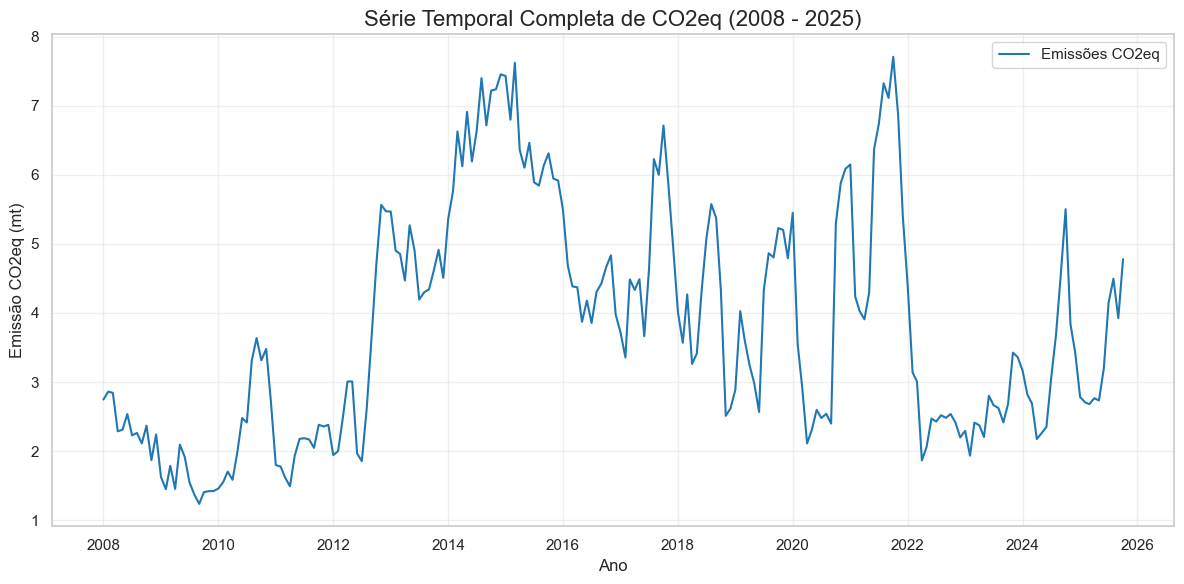

In [3]:
# Configurar a figura
fig, ax = plt.subplots(figsize=(12, 6))

# Plotar a série completa
ax.plot(df_focado['data'], df_focado['co2_mt'], linestyle='-', color='tab:blue', label='Emissões CO2eq')

# Estilização do gráfico
ax.set_title('Série Temporal Completa de CO2eq (2008 - 2025)', fontsize=16)
ax.set_ylabel('Emissão CO2eq (mt)')
ax.set_xlabel('Ano')
ax.grid(True, alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

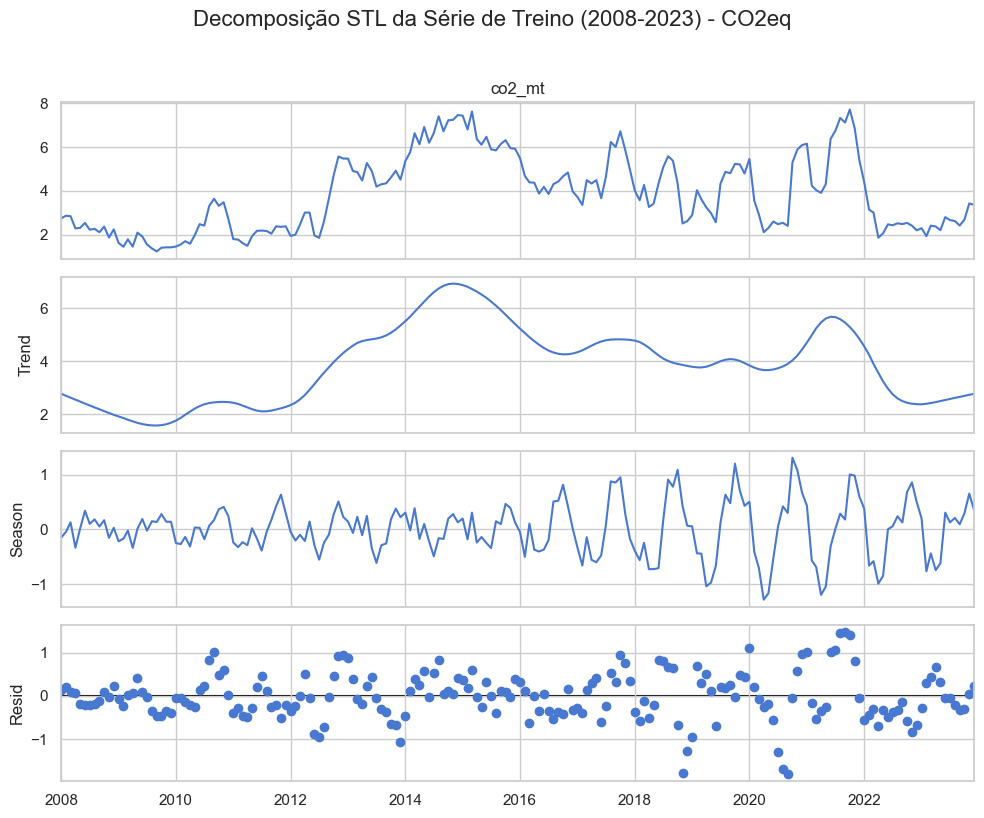

In [4]:
# Decomposição STL

# Aplicar STL (period=12 para dados mensais)
stl = STL(treino, period=12)
result = stl.fit()

# Plotar os componentes (Observado, Tendência, Sazonalidade, Resíduos)
fig = result.plot()
fig.set_size_inches(10, 8)

# Ajustes visuais
plt.suptitle('Decomposição STL da Série de Treino (2008-2023) - CO2eq', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

Lambda ótimo encontrado (Guerrero): 0.2786


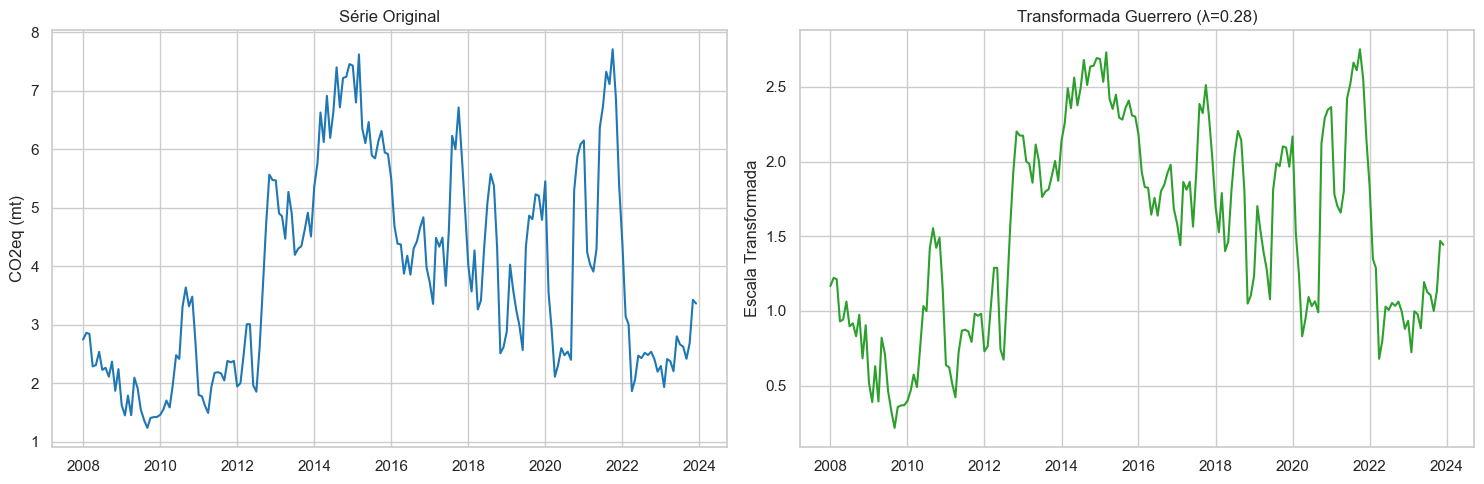

In [5]:
# 1. Instanciar o transformador Guerrero (sp=12)
transformer = BoxCoxTransformer(method='guerrero', sp=12)

# 2. Fit no treino para achar o Lambda
transformer.fit(treino)
lambda_guerrero = transformer.lambda_

# 3. Transformar a série de treino
treino_guerrero = transformer.transform(treino)
treino_guerrero = pd.Series(treino_guerrero.values.flatten(), index=treino.index)

print(f"Lambda ótimo encontrado (Guerrero): {lambda_guerrero:.4f}")

# Visualização Comparativa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Original
ax1.plot(treino, color='tab:blue')
ax1.set_title('Série Original')
ax1.set_ylabel('CO2eq (mt)')

# Transformada
ax2.plot(treino_guerrero, color='tab:green')
ax2.set_title(f'Transformada Guerrero (λ={lambda_guerrero:.2f})')
ax2.set_ylabel('Escala Transformada')

plt.tight_layout()
plt.show()

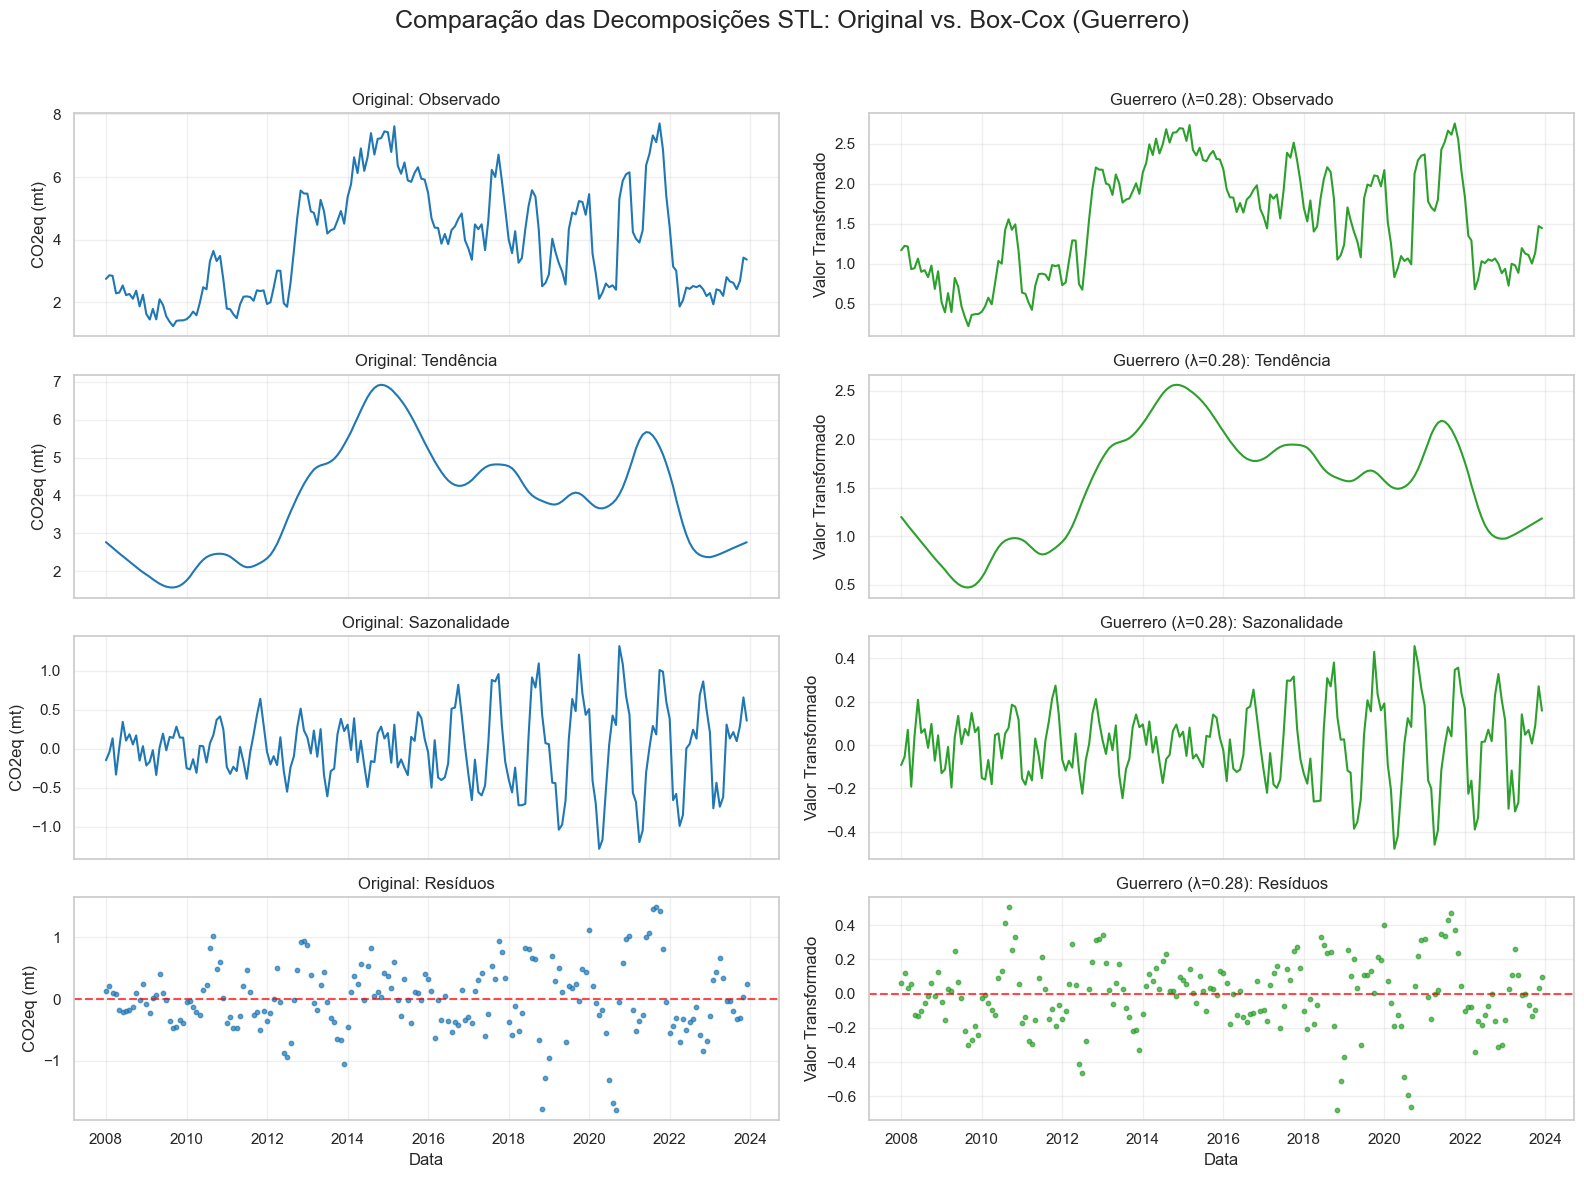

In [6]:

# Comparação das Decomposições STL (Original vs. Guerrero)

# 1. Calcular o STL da série transformada
stl_guerrero = STL(treino_guerrero, period=12)
result_guerrero = stl_guerrero.fit()

# 2. Criar figura 4x2 
fig, axes = plt.subplots(4, 2, figsize=(16, 12), sharex=True)

#Coluna 1: Série Original 

# Observado

axes[0, 0].plot(result.observed, color='tab:blue')

axes[0, 0].set_title('Original: Observado')

axes[0, 0].set_ylabel('CO2eq (mt)')

axes[0, 0].grid(True, alpha=0.3)

# Tendência

axes[1, 0].plot(result.trend, color='tab:blue')

axes[1, 0].set_title('Original: Tendência')

axes[1, 0].set_ylabel('CO2eq (mt)')

axes[1, 0].grid(True, alpha=0.3)

# Sazonalidade

axes[2, 0].plot(result.seasonal, color='tab:blue')

axes[2, 0].set_title('Original: Sazonalidade')

axes[2, 0].set_ylabel('CO2eq (mt)')

axes[2, 0].grid(True, alpha=0.3)

# Resíduos (Scatter plot)

axes[3, 0].scatter(result.resid.index, result.resid.values, s=10, alpha=0.7, color='tab:blue')

axes[3, 0].set_title('Original: Resíduos')

axes[3, 0].set_ylabel('CO2eq (mt)')

axes[3, 0].axhline(0, color='red', linestyle='--', alpha=0.7)

axes[3, 0].grid(True, alpha=0.3)

axes[3, 0].set_xlabel('Data')

#Coluna 2: Série Transformada (Guerrero)

# Observado

axes[0, 1].plot(result_guerrero.observed, color='tab:green')

axes[0, 1].set_title(f'Guerrero (λ={lambda_guerrero:.2f}): Observado')

axes[0, 1].set_ylabel('Valor Transformado')

axes[0, 1].grid(True, alpha=0.3)

# Tendência

axes[1, 1].plot(result_guerrero.trend, color='tab:green')

axes[1, 1].set_title(f'Guerrero (λ={lambda_guerrero:.2f}): Tendência')

axes[1, 1].set_ylabel('Valor Transformado')

axes[1, 1].grid(True, alpha=0.3)

# Sazonalidade

axes[2, 1].plot(result_guerrero.seasonal, color='tab:green')

axes[2, 1].set_title(f'Guerrero (λ={lambda_guerrero:.2f}): Sazonalidade')

axes[2, 1].set_ylabel('Valor Transformado')

axes[2, 1].grid(True, alpha=0.3)

# Resíduos (Scatter plot)

axes[3, 1].scatter(result_guerrero.resid.index, result_guerrero.resid.values, s=10, alpha=0.7, color='tab:green')

axes[3, 1].set_title(f'Guerrero (λ={lambda_guerrero:.2f}): Resíduos')

axes[3, 1].set_ylabel('Valor Transformado')

axes[3, 1].axhline(0, color='red', linestyle='--', alpha=0.7)

axes[3, 1].grid(True, alpha=0.3)

axes[3, 1].set_xlabel('Data')

# plot

plt.suptitle('Comparação das Decomposições STL: Original vs. Box-Cox (Guerrero)', fontsize=18)

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

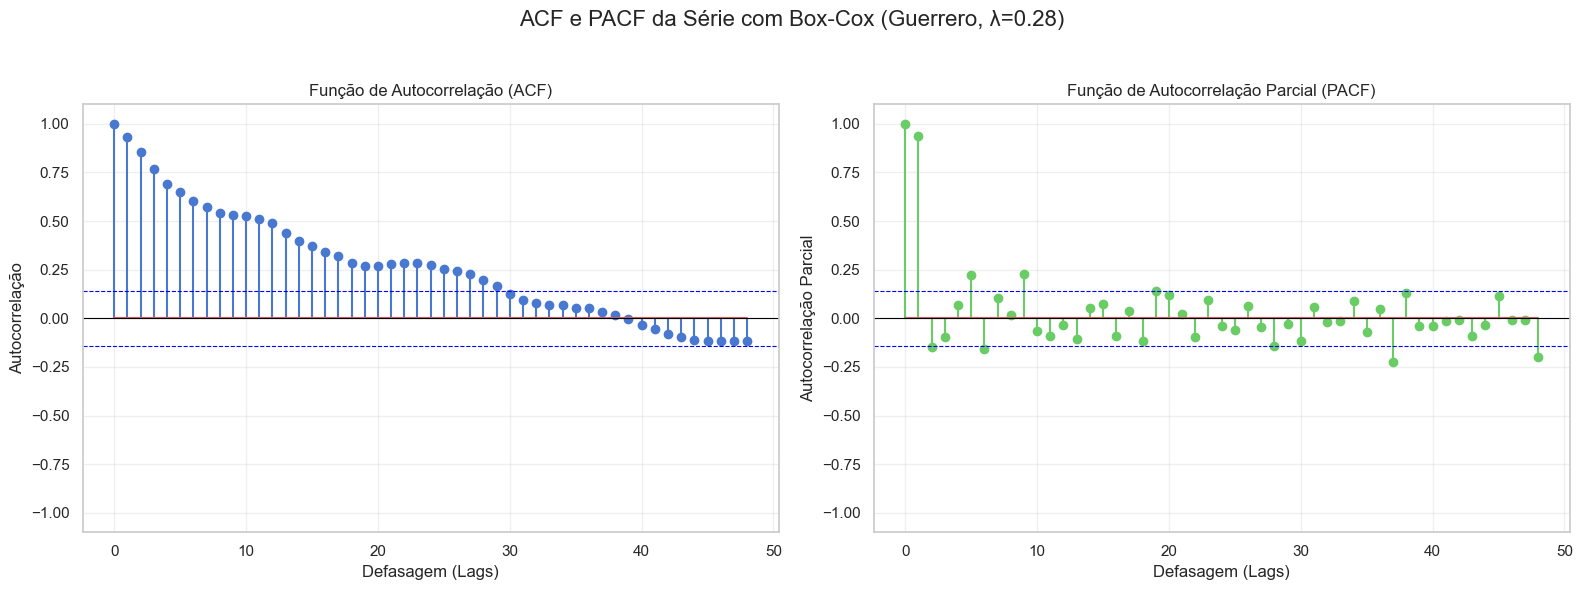

In [7]:
# ACF e PACF da Série Transformada (Guerrero) no Estilo Spike

# 1. Calcular os valores de ACF e PACF
lags = 48
acf_vals = acf(treino_guerrero, nlags=lags)
pacf_vals = pacf(treino_guerrero, nlags=lags)

# 2. Calcular o intervalo de confiança 
n_obs = len(treino_guerrero)
conf_interval = 1.96 / np.sqrt(n_obs)

# 3. Criar a figura com dois subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: ACF (Estilo "Spike")
ax1.stem(range(len(acf_vals)), acf_vals, linefmt='b-', markerfmt='bo', basefmt='r-')
ax1.set_title('Função de Autocorrelação (ACF)')
ax1.set_xlabel('Defasagem (Lags)')
ax1.set_ylabel('Autocorrelação')
ax1.axhline(0, color='black', linewidth=0.8)
ax1.axhline(conf_interval, color='blue', linestyle='--', linewidth=0.8)
ax1.axhline(-conf_interval, color='blue', linestyle='--', linewidth=0.8)
ax1.set_ylim(-1.1, 1.1)
ax1.grid(True, alpha=0.3)

# Gráfico 2: PACF (Estilo Spike)
ax2.stem(range(len(pacf_vals)), pacf_vals, linefmt='g-', markerfmt='go', basefmt='r-')
ax2.set_title('Função de Autocorrelação Parcial (PACF)')
ax2.set_xlabel('Defasagem (Lags)')
ax2.set_ylabel('Autocorrelação Parcial')
ax2.axhline(0, color='black', linewidth=0.8)
ax2.axhline(conf_interval, color='blue', linestyle='--', linewidth=0.8)
ax2.axhline(-conf_interval, color='blue', linestyle='--', linewidth=0.8)
ax2.set_ylim(-1.1, 1.1)
ax2.grid(True, alpha=0.3)

# Título geral e layout 
lambda_round = np.round(lambda_guerrero, 2)
plt.suptitle(f'ACF e PACF da Série com Box-Cox (Guerrero, λ={lambda_round:.2f})', fontsize=16) 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

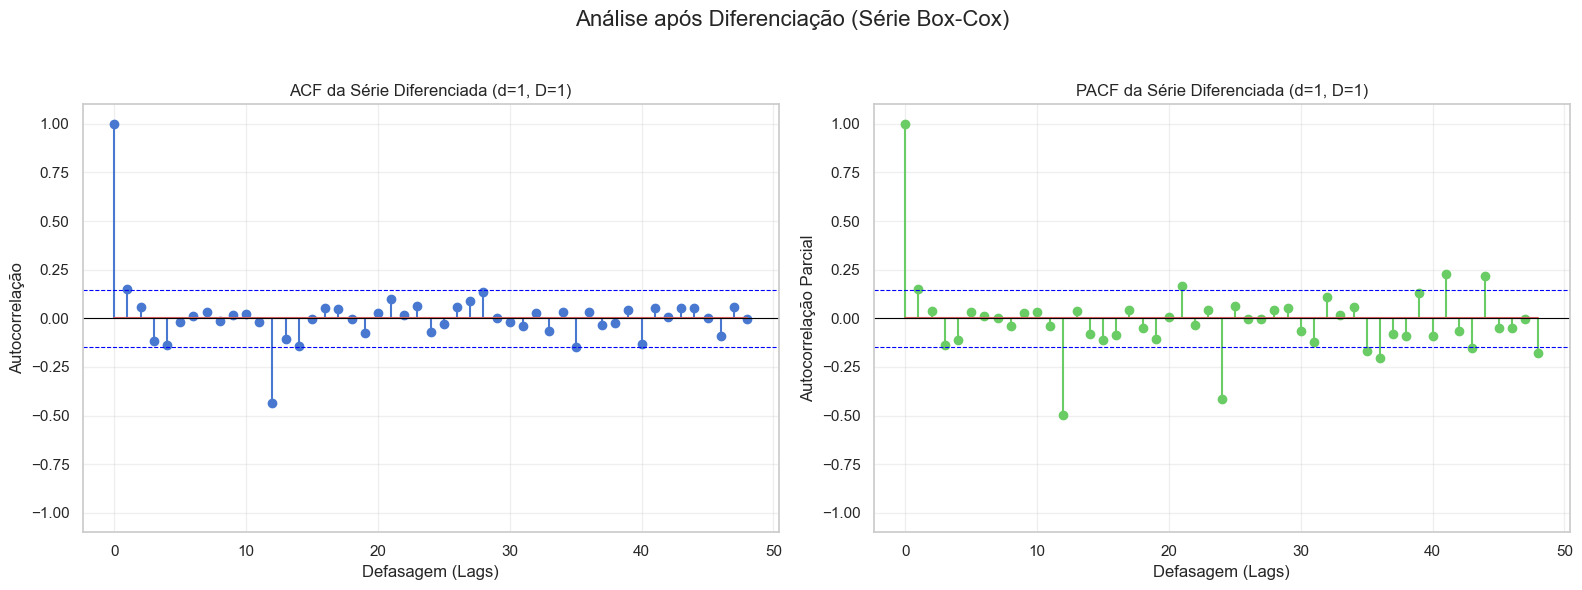

In [8]:
# Aplicando Diferenciação (d=1 e D=1)

# 1. Aplicar diferenciação sazonal (D=1, m=12) e depois não sazonal (d=1).

# O .dropna() é crucial para remover os 13 valores NaN gerados pelas diferenciações.
serie_diff = treino_guerrero.diff(12).diff(1).dropna()

# 2. Calcular os valores de ACF e PACF para a série diferenciada
lags = 48
acf_vals_diff = acf(serie_diff, nlags=lags)
pacf_vals_diff = pacf(serie_diff, nlags=lags)

# 3. Recalcular o intervalo de confiança () pois removemos 13 observações)
n_obs_diff = len(serie_diff)
conf_interval_diff = 1.96 / np.sqrt(n_obs_diff)

# 4. Plotagem dos Gráficos ACF e PACF da Série Diferenciada
# Criar a figura com os novos gráficos
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# 4. Gráfico 1: ACF da Série Diferenciada (Estilo "Spike")
ax1.stem(range(len(acf_vals_diff)), acf_vals_diff, linefmt='b-', markerfmt='bo', basefmt='r-')
ax1.set_title('ACF da Série Diferenciada (d=1, D=1)')
ax1.set_xlabel('Defasagem (Lags)')
ax1.set_ylabel('Autocorrelação')
ax1.grid(True, alpha=0.3)
ax1.axhline(0, color='black', linewidth=0.8)
ax1.axhline(conf_interval_diff, color='blue', linestyle='--', linewidth=0.8)
ax1.axhline(-conf_interval_diff, color='blue', linestyle='--', linewidth=0.8)
ax1.set_ylim(-1.1, 1.1)

# Gráfico 2: PACF da Série Diferenciada (Estilo "Spike")
ax2.stem(range(len(pacf_vals_diff)), pacf_vals_diff, linefmt='g-', markerfmt='go', basefmt='r-')
ax2.set_title('PACF da Série Diferenciada (d=1, D=1)')
ax2.set_xlabel('Defasagem (Lags)')
ax2.set_ylabel('Autocorrelação Parcial')
ax2.grid(True, alpha=0.3)
ax2.axhline(0, color='black', linewidth=0.8)
ax2.axhline(conf_interval_diff, color='blue', linestyle='--', linewidth=0.8)
ax2.axhline(-conf_interval_diff, color='blue', linestyle='--', linewidth=0.8)
ax2.set_ylim(-1.1, 1.1)

plt.suptitle('Análise após Diferenciação (Série Box-Cox)', fontsize=16) 
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  192
Model:             SARIMAX(0, 1, 0)x(2, 1, [1], 12)   Log Likelihood                  -4.550
Date:                              Mon, 24 Nov 2025   AIC                             19.100
Time:                                      13:07:39   BIC                             35.037
Sample:                                  01-01-2008   HQIC                            25.562
                                       - 12-01-2023                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0008      0.004     -0.188      0.851      -0.009       0.008
ar.S.L12       0.01

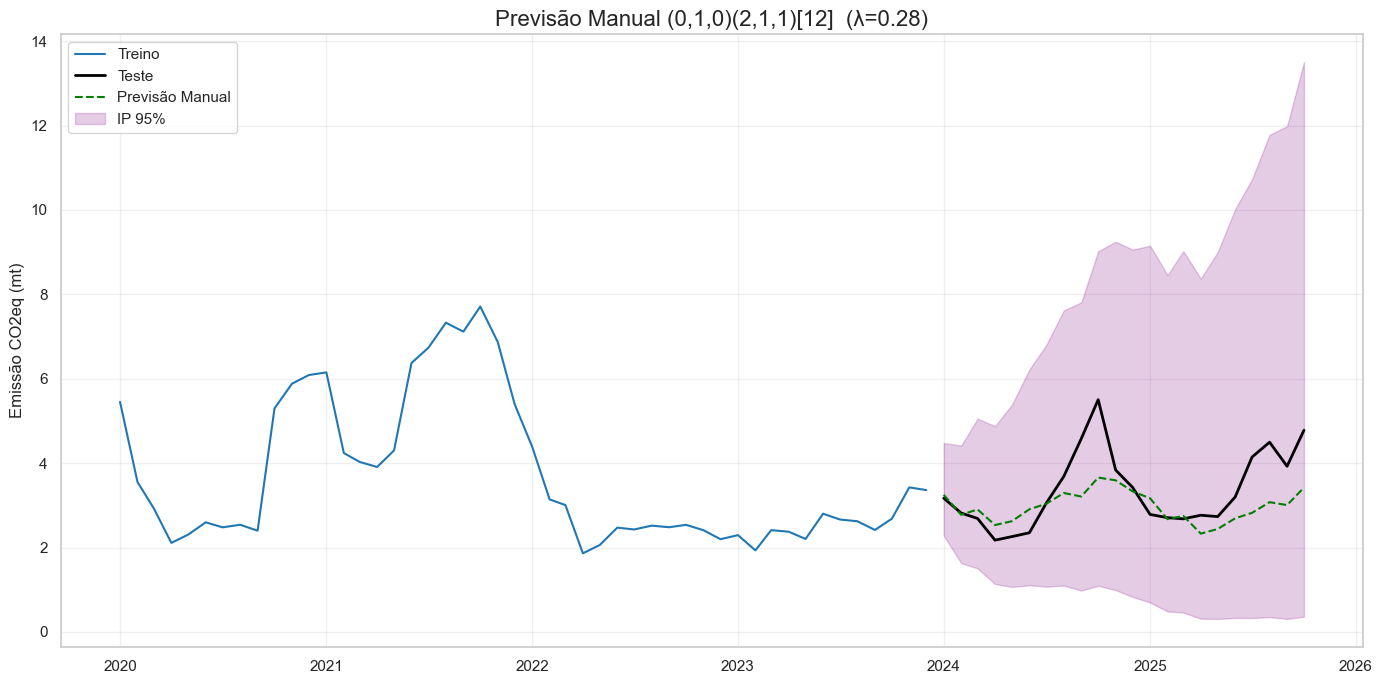

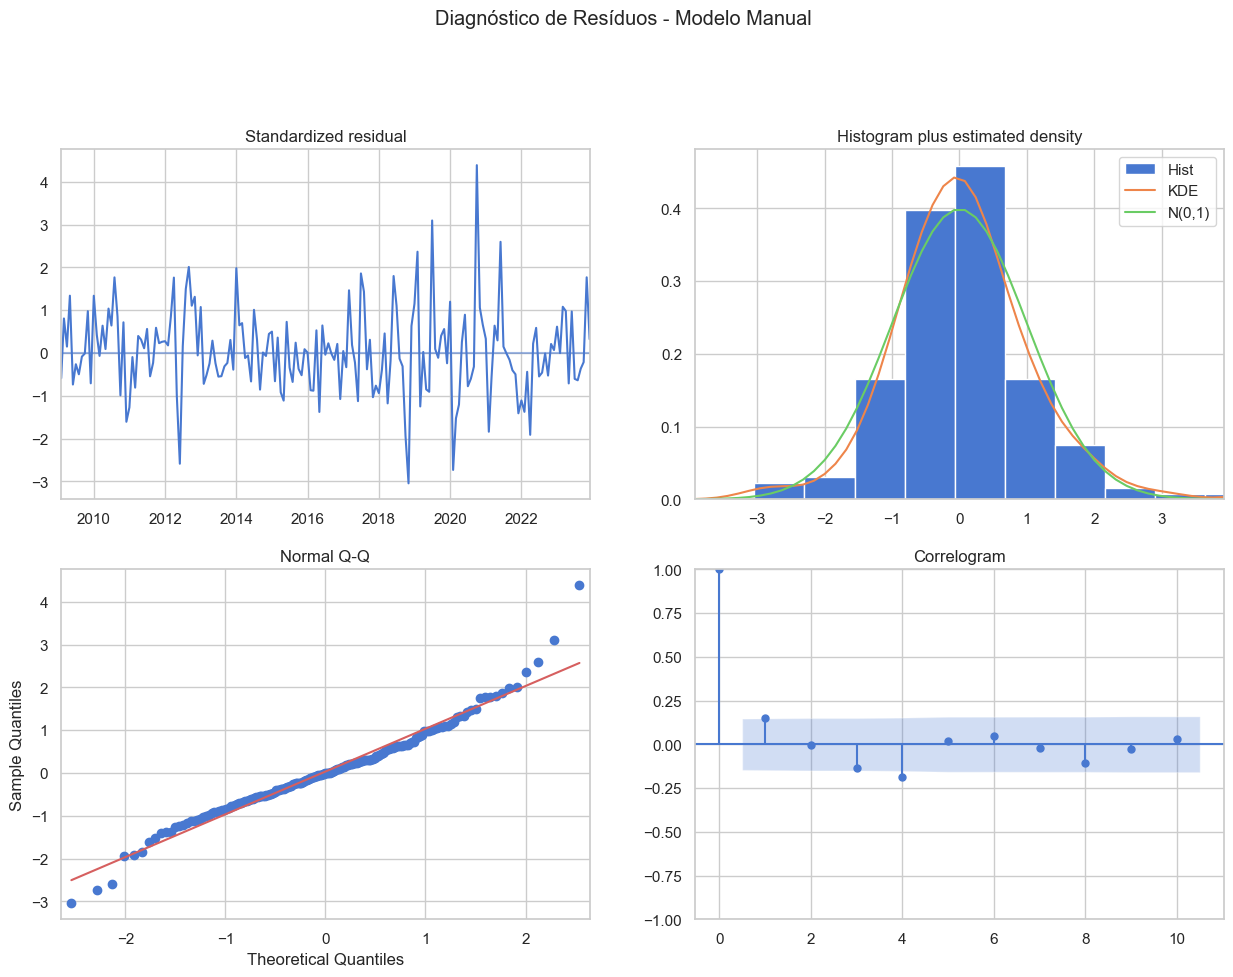

In [9]:
# Modelo SARIMA Manual
modelo_manual_pm = pm.ARIMA(
    order=(0, 1, 0),              # (p, d, q)
    seasonal_order=(2, 1, 1, 12), # (P, D, Q, m)
    suppress_warnings=True        # Ignora avisos de convergência irrelevantes
)

modelo_manual_pm.fit(treino_guerrero)

print(modelo_manual_pm.summary())

# Previsão e Inversão da Transformação

n_periodos = len(teste)

pred_boxcox, conf_int_boxcox = modelo_manual_pm.predict(
    n_periods=n_periodos, 
    return_conf_int=True,
    alpha=0.05
)

# Reverter Box-Cox (Voltar para a escala original)
pred_final_manual = inv_boxcox(pred_boxcox, lambda_guerrero)
conf_int_final_manual = inv_boxcox(conf_int_boxcox, lambda_guerrero)

# Avaliação de Métricas

mae_manual = mean_absolute_error(teste, pred_final_manual)
rmse_manual = np.sqrt(mean_squared_error(teste, pred_final_manual))

print(f"\n--- Resultados Modelo Manual ---")
print(f"MAE:  {mae_manual:.4f}")
print(f"RMSE: {rmse_manual:.4f}")

# Plot

fig, ax = plt.subplots(figsize=(14, 7))

# Dados de Treino
ax.plot(treino.index[-48:], treino.tail(48), label='Treino', color='tab:blue')

# Dados Reais 
ax.plot(teste.index, teste, label='Teste', color='black', linewidth=2)

# Previsão
ax.plot(teste.index, pred_final_manual, label='Previsão Manual', color='green', linestyle='--')

# Intervalo de Previsão
ax.fill_between(
    teste.index,
    conf_int_final_manual[:, 0],
    conf_int_final_manual[:, 1], 
    color='purple', alpha=0.2, label='IP 95%'
)

ax.set_title(f'Previsão Manual (0,1,0)(2,1,1)[12]  (λ={lambda_guerrero:.2f})', fontsize=16)
ax.set_ylabel('Emissão CO2eq (mt)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Diagnósticos
modelo_manual_pm.plot_diagnostics(figsize=(15, 10))
plt.suptitle('Diagnóstico de Resíduos - Modelo Manual', y=1.02)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,1)[12] intercept   : AIC=0.949, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=4.671, Time=0.05 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-0.285, Time=0.23 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=0.869, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=2.678, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=4.678, Time=0.04 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=0.480, Time=0.36 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=-4.456, Time=0.38 sec
 ARIMA(1,1,0)(0,0,1)[12] intercept   : AIC=0.627, Time=0.13 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=-2.680, Time=1.33 sec
 ARIMA(1,1,0)(1,0,2)[12] intercept   : AIC=-2.701, Time=1.17 sec
 ARIMA(1,1,0)(0,0,2)[12] intercept   : AIC=1.690, Time=0.41 sec
 ARIMA(1,1,0)(2,0,2)[12] intercept   : AIC=inf, Time=1.30 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-2.975, Time=0.35 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=-2.468, Time=0.

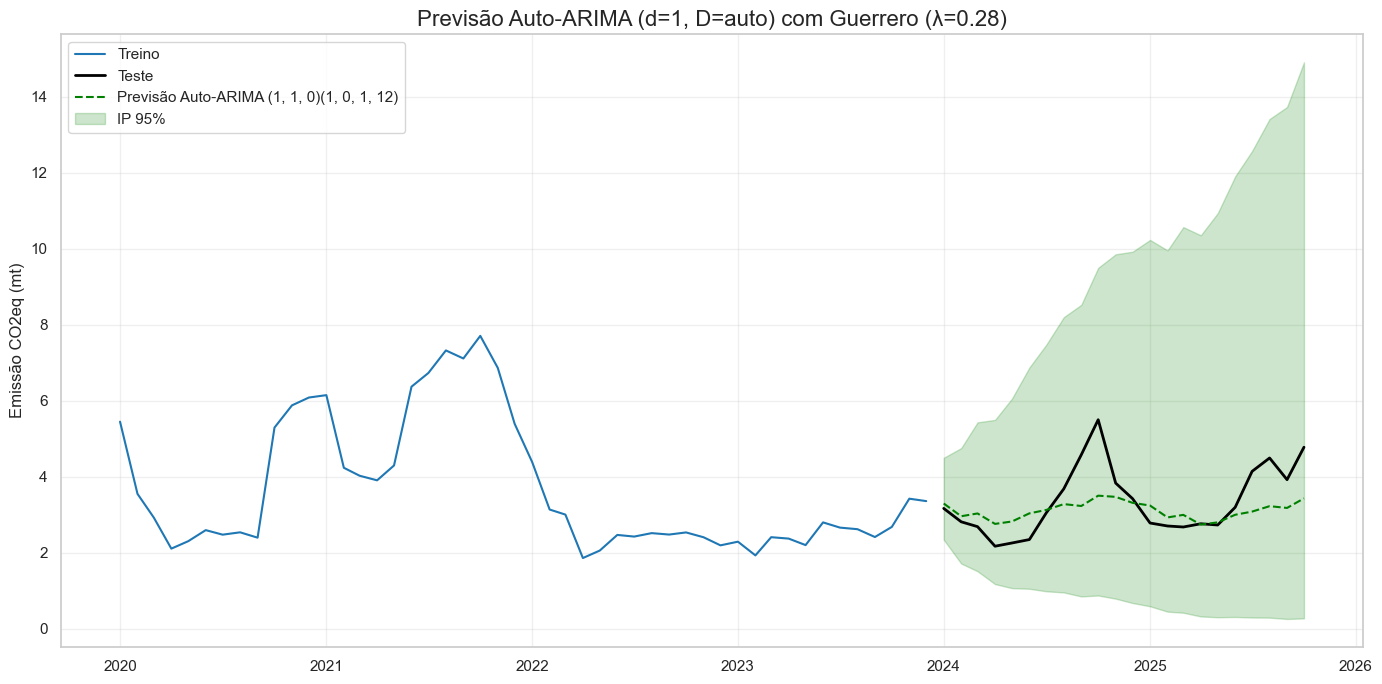

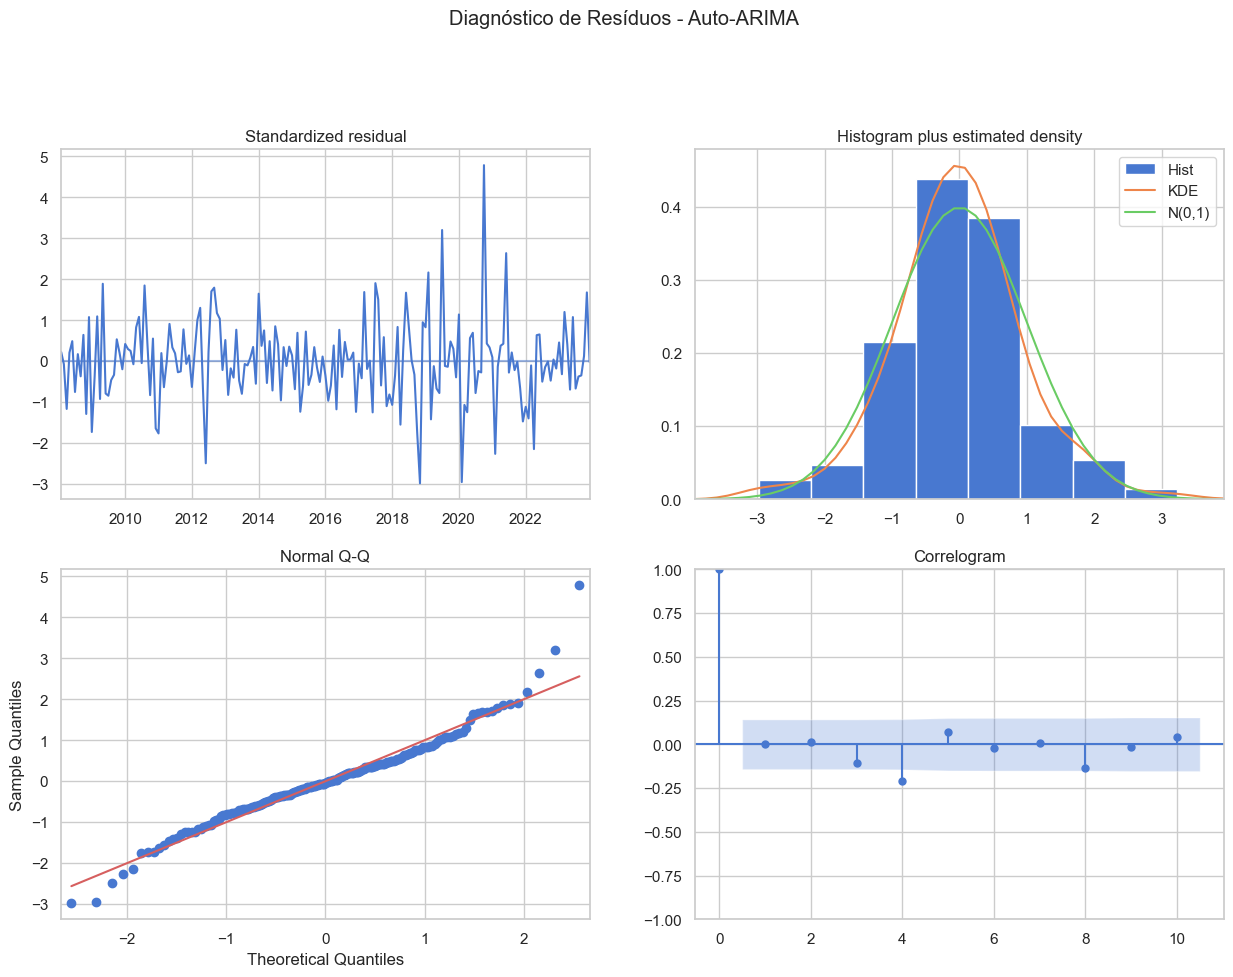

In [10]:
# Treinamento Auto-ARIMA (d=1 fixo, D automático)

# Configuração
modelo_auto_d_travado = pm.auto_arima(
    treino_guerrero,              # Série transformada
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    m=12,                         # Período sazonal
    start_P=0, 
    seasonal=True,                # Habilita o SARIMA
    d=1,                          # Força diferenciação de tendência
    D=None,                       # Deixa o teste encontrar o D
    seasonal_test='ocsb',         # Teste específico para sazonalidade
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

print("\n--- Melhor modelo encontrado ---")
print(modelo_auto_d_travado.summary())

# Previsão e Inversão da Transformação

n_periodos = len(teste)

# Gerar previsões
pred_boxcox_auto, conf_int_boxcox_auto = modelo_auto_d_travado.predict(
    n_periods=n_periodos, 
    return_conf_int=True,
    alpha=0.05
)

# Reverter Box-Cox (Voltar para CO2eq real)
pred_final_auto = inv_boxcox(pred_boxcox_auto, lambda_guerrero)
conf_int_final_auto = inv_boxcox(conf_int_boxcox_auto, lambda_guerrero)

# Avaliação de Métricas

mae_auto = mean_absolute_error(teste, pred_final_auto)
rmse_auto = np.sqrt(mean_squared_error(teste, pred_final_auto))

print(f"\n--- Resultados Auto-ARIMA (d=1, D=auto) ---")
print(f"MAE:  {mae_auto:.4f}")
print(f"RMSE: {rmse_auto:.4f}")

# Gráfico 1: Previsão vs Real

fig, ax = plt.subplots(figsize=(14, 7))

# Dados de Treino
ax.plot(treino.index[-48:], treino.tail(48), label='Treino', color='tab:blue')

# Dados Reais (Teste)
ax.plot(teste.index, teste, label='Teste', color='black', linewidth=2)

# Previsão
ax.plot(teste.index, pred_final_auto, label=f'Previsão Auto-ARIMA {modelo_auto_d_travado.order}{modelo_auto_d_travado.seasonal_order}', color='green', linestyle='--')

# Intervalo de Previsão
ax.fill_between(
    teste.index,
    conf_int_final_auto[:, 0], 
    conf_int_final_auto[:, 1], 
    color='green', alpha=0.2, label='IP 95%'
)

ax.set_title(f'Previsão Auto-ARIMA (d=1, D=auto) com Guerrero (λ={lambda_guerrero:.2f})', fontsize=16)
ax.set_ylabel('Emissão CO2eq (mt)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico 2: Diagnóstico dos Resíduos
modelo_auto_d_travado.plot_diagnostics(figsize=(15, 10))
plt.suptitle('Diagnóstico de Resíduos - Auto-ARIMA', y=1.02)
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,1)[12] intercept   : AIC=349.911, Time=0.16 sec
 ARIMA(0,0,0)(0,1,0)[12] intercept   : AIC=370.038, Time=0.05 sec
 ARIMA(1,0,0)(1,1,0)[12] intercept   : AIC=52.916, Time=0.34 sec
 ARIMA(0,0,1)(0,1,1)[12] intercept   : AIC=186.421, Time=0.30 sec
 ARIMA(0,0,0)(0,1,0)[12]             : AIC=368.057, Time=0.02 sec
 ARIMA(1,0,0)(0,1,0)[12] intercept   : AIC=89.951, Time=0.05 sec
 ARIMA(1,0,0)(2,1,0)[12] intercept   : AIC=34.668, Time=0.87 sec
 ARIMA(1,0,0)(2,1,1)[12] intercept   : AIC=15.589, Time=1.66 sec
 ARIMA(1,0,0)(1,1,1)[12] intercept   : AIC=inf, Time=0.73 sec
 ARIMA(1,0,0)(2,1,2)[12] intercept   : AIC=inf, Time=2.61 sec
 ARIMA(1,0,0)(1,1,2)[12] intercept   : AIC=inf, Time=2.45 sec
 ARIMA(0,0,0)(2,1,1)[12] intercept   : AIC=352.073, Time=0.70 sec
 ARIMA(2,0,0)(2,1,1)[12] intercept   : AIC=11.481, Time=2.68 sec
 ARIMA(2,0,0)(1,1,1)[12] intercept   : AIC=9.634, Time=1.32 sec
 ARIMA(2,0,0)(0,1,1)[12] intercept   : AIC=7.935, Ti

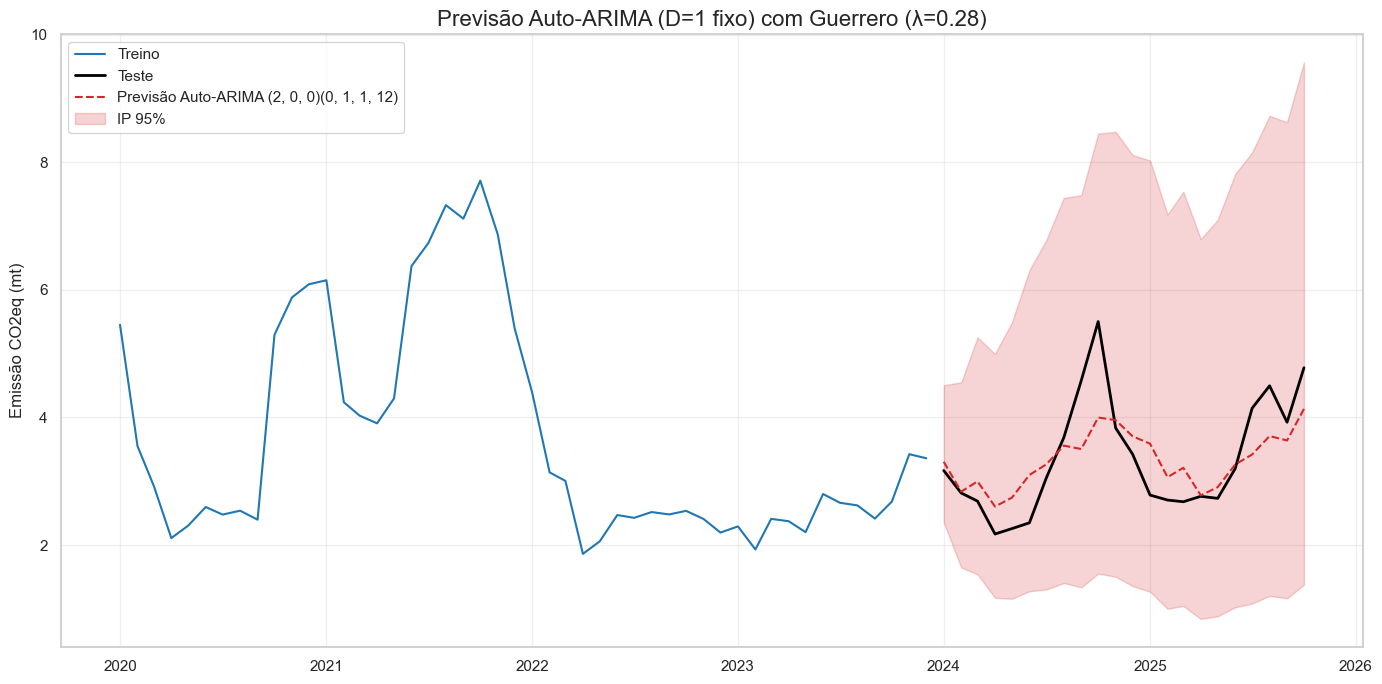

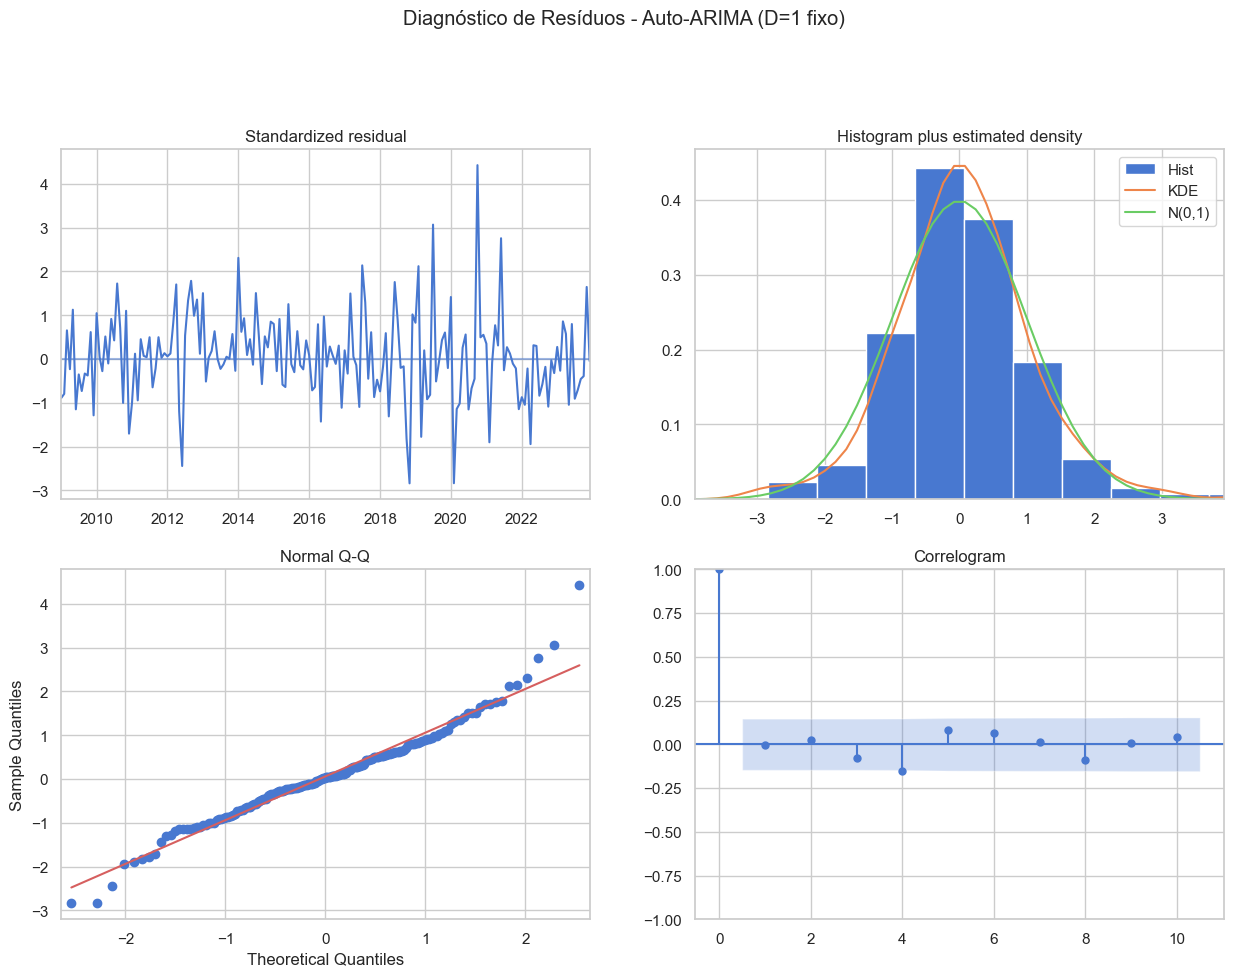

In [11]:
# Treinamento do Auto-ARIMA (D=1 fixo, d via teste ADF)
# Configuração
modelo_auto_D_travado = pm.auto_arima(
    treino_guerrero,              # Série transformada
    start_p=0, start_q=0,
    test='adf',                   # Teste para achar o d (Tendência)
    max_p=3, max_q=3,             # Limites não sazonais
    m=12,                         # Período sazonal
    start_P=0, 
    seasonal=True,                # Habilita o SARIMA
    d=None,                       # teste 'adf' encontrar o d
    D=1,                          # Força a diferenciação sazonal
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

print("\n--- Melhor modelo encontrado ---")
print(modelo_auto_D_travado.summary())

# Previsão e Inversão da Transformação

n_periodos = len(teste)

# Gerar previsões
pred_boxcox_D, conf_int_boxcox_D = modelo_auto_D_travado.predict(
    n_periods=n_periodos, 
    return_conf_int=True,
    alpha=0.05
)

# Reverter Box-Cox (Voltar para CO2eq real)
pred_final_D = inv_boxcox(pred_boxcox_D, lambda_guerrero)
conf_int_final_D = inv_boxcox(conf_int_boxcox_D, lambda_guerrero)

# Avaliação de Métricas
mae_D = mean_absolute_error(teste, pred_final_D)
rmse_D = np.sqrt(mean_squared_error(teste, pred_final_D))

print(f"\n--- Resultados Auto-ARIMA (D=1 fixo, d=auto) ---")
print(f"MAE:  {mae_D:.4f}")
print(f"RMSE: {rmse_D:.4f}")

# Gráfico 1: Previsão vs Real

fig, ax = plt.subplots(figsize=(14, 7))

# Dados de Treino (Recente)
ax.plot(treino.index[-48:], treino.tail(48), label='Treino', color='tab:blue')

# Dados Reais (Teste)
ax.plot(teste.index, teste, label='Teste', color='black', linewidth=2)

# Previsão
ax.plot(teste.index, pred_final_D, label=f'Previsão Auto-ARIMA {modelo_auto_D_travado.order}{modelo_auto_D_travado.seasonal_order}', color='tab:red', linestyle='--')

# Intervalo de previsão
ax.fill_between(
    teste.index,
    conf_int_final_D[:, 0], 
    conf_int_final_D[:, 1], 
    color='tab:red', alpha=0.2, label='IP 95%'
)

ax.set_title(f'Previsão Auto-ARIMA (D=1 fixo) com Guerrero (λ={lambda_guerrero:.2f})', fontsize=16)
ax.set_ylabel('Emissão CO2eq (mt)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico 2: Diagnóstico dos Resíduos
modelo_auto_D_travado.plot_diagnostics(figsize=(15, 10))
plt.suptitle('Diagnóstico de Resíduos - Auto-ARIMA (D=1 fixo)', y=1.02)
plt.show()

--- Iniciando Auto-ARIMA (d=1 e D=1 fixos) ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=13.618, Time=0.20 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=94.163, Time=0.03 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=54.206, Time=0.15 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=11.393, Time=0.35 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=92.415, Time=0.06 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=13.309, Time=0.51 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=13.299, Time=0.82 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=54.337, Time=0.14 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=2.32 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=13.368, Time=0.54 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=13.311, Time=0.58 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=11.460, Time=0.45 sec
 ARIMA(1,1,2)(0,1,1)[12]             : AIC=11.228, Time=1.17 sec
 ARIMA(1,1,2)(0,1,0)[12]             : AIC=94.292, Time=0.14 sec
 AR

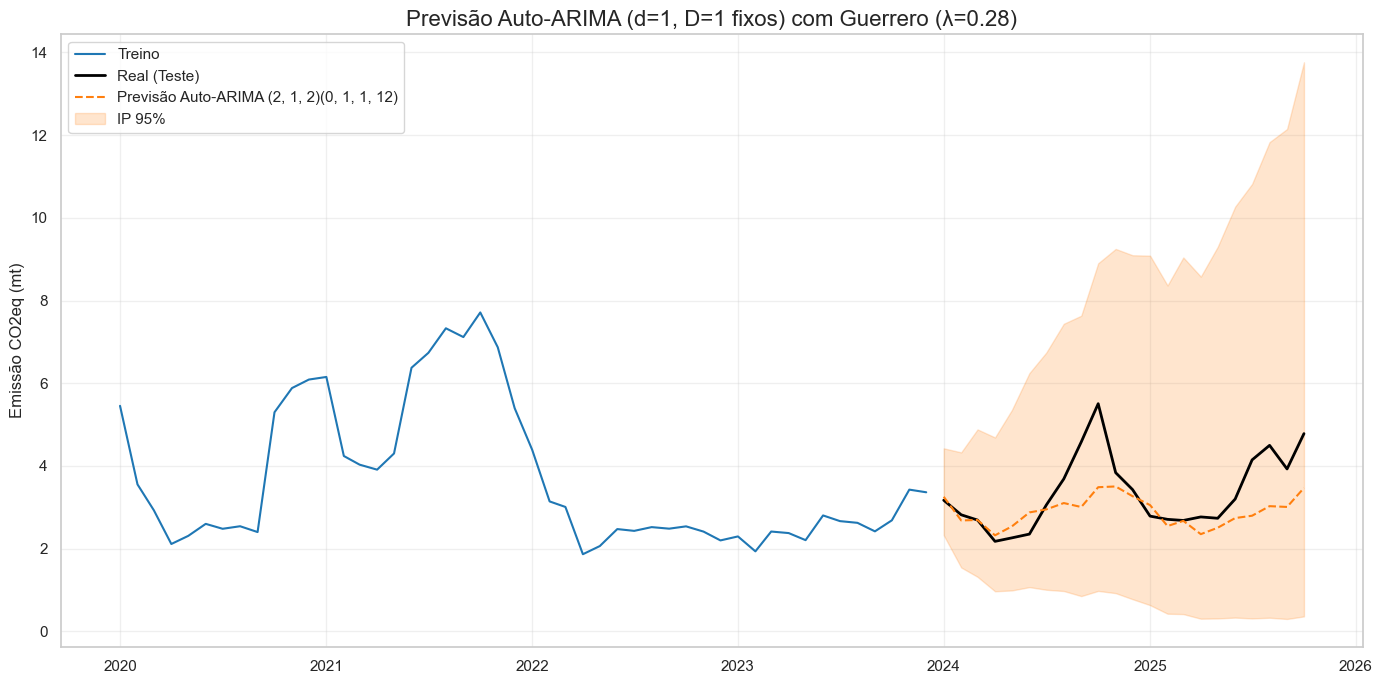

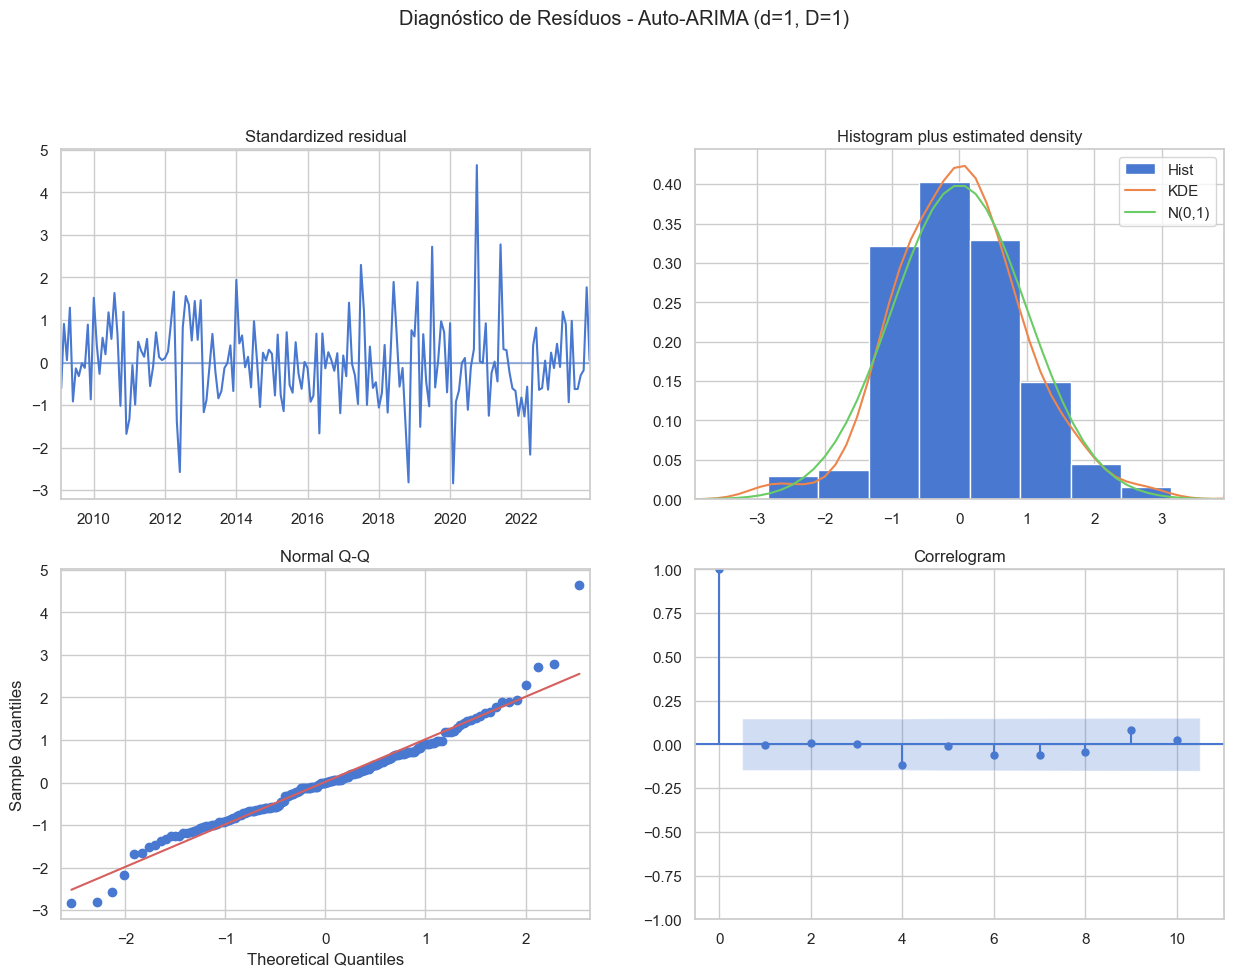

In [12]:
# Treinamento do Auto-ARIMA (d=1 e D=1 fixos)
print("--- Iniciando Auto-ARIMA (d=1 e D=1 fixos) ---")

# Configuração 
modelo_auto_dD_travado = pm.auto_arima(
    treino_guerrero,              # Série transformada
    start_p=0, start_q=0,
    max_p=3, max_q=3,
    m=12,                         # Período sazonal
    start_P=0, 
    seasonal=True,                # Habilita o SARIMA
    d=1,                          # Força diferenciação de tendência
    D=1,                          # Força diferenciação sazonal
    trace=True,
    error_action='ignore',  
    suppress_warnings=True, 
    stepwise=True
)

print("\n--- Melhor modelo encontrado (d=1, D=1) ---")
print(modelo_auto_dD_travado.summary())

# Previsão e Inversão da Transformação

n_periodos = len(teste)

# Gerar previsões
pred_boxcox_dD, conf_int_boxcox_dD = modelo_auto_dD_travado.predict(
    n_periods=n_periodos, 
    return_conf_int=True,
    alpha=0.05
)

# Reverter Box-Cox (Voltar para CO2eq real)
pred_final_dD = inv_boxcox(pred_boxcox_dD, lambda_guerrero)
conf_int_final_dD = inv_boxcox(conf_int_boxcox_dD, lambda_guerrero)

# Avaliação de Métricas
mae_dD = mean_absolute_error(teste, pred_final_dD)
rmse_dD = np.sqrt(mean_squared_error(teste, pred_final_dD))

print(f"\n--- Resultados Auto-ARIMA (d=1, D=1 fixos) ---")
print(f"MAE:  {mae_dD:.4f}")
print(f"RMSE: {rmse_dD:.4f}")

# Gráfico 1: Previsão vs Real

fig, ax = plt.subplots(figsize=(14, 7))

# Dados de Treino (Recente)
ax.plot(treino.index[-48:], treino.tail(48), label='Treino', color='tab:blue')

# Dados Reais (Teste)
ax.plot(teste.index, teste, label='Real (Teste)', color='black', linewidth=2)

# Previsão
ax.plot(teste.index, pred_final_dD, label=f'Previsão Auto-ARIMA {modelo_auto_dD_travado.order}{modelo_auto_dD_travado.seasonal_order}', color='tab:orange', linestyle='--')

# Intervalo de Previsão
ax.fill_between(
    teste.index,
    conf_int_final_dD[:, 0], 
    conf_int_final_dD[:, 1], 
    color='tab:orange', alpha=0.2, label='IP 95%'
)

ax.set_title(f'Previsão Auto-ARIMA (d=1, D=1 fixos) com Guerrero (λ={lambda_guerrero:.2f})', fontsize=16)
ax.set_ylabel('Emissão CO2eq (mt)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Gráfico 2: Diagnóstico dos Resíduos
modelo_auto_dD_travado.plot_diagnostics(figsize=(15, 10))
plt.suptitle('Diagnóstico de Resíduos - Auto-ARIMA (d=1, D=1)', y=1.02)
plt.show()

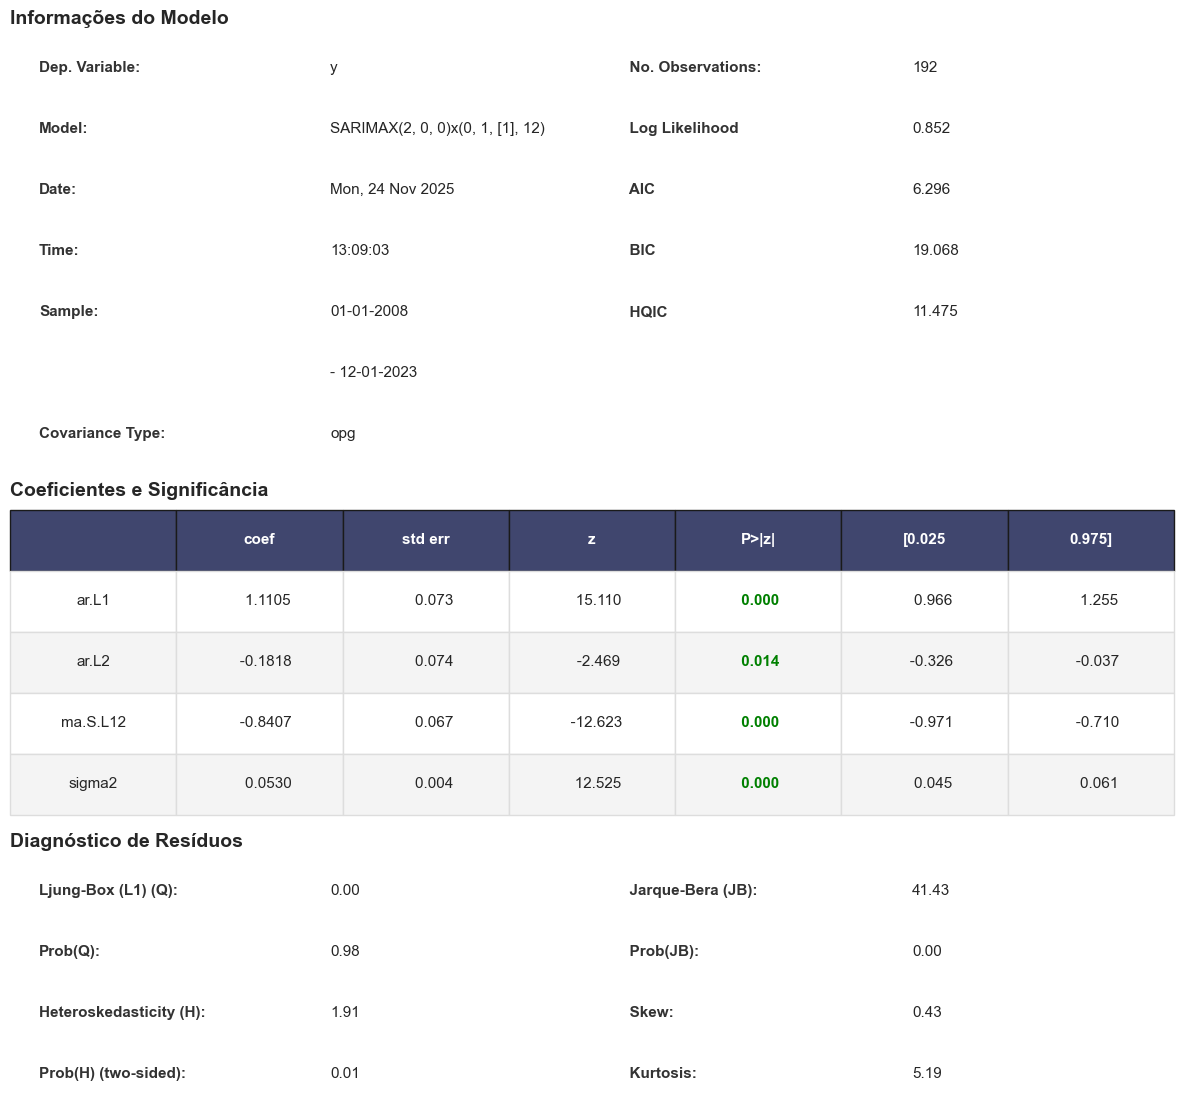

Imagem salva com sucesso: estatisticas_auto_arima.png


In [ ]:
def gerar_imagem_summary_arima(modelo, nome_arquivo='summary_arima_stats.png'):
    """
    Converte o sumário estatístico do modelo ARIMA/SARIMAX em uma imagem PNG formatada.
    """
    summary = modelo.summary()
    
    # Extração Manual dos Dados
    # Tabela 0: Informações Gerais
    data_info = summary.tables[0].data
    df_info = pd.DataFrame(data_info)
    
    # Tabela 1: Coeficientes 
    data_coef = summary.tables[1].data
    header_coef = data_coef[0] # Primeira linha é cabeçalho
    rows_coef = data_coef[1:]
    df_coef = pd.DataFrame(rows_coef, columns=header_coef)
    
    # Tabela 2: Diagnósticos
    data_diag = summary.tables[2].data
    df_diag = pd.DataFrame(data_diag)

    # Configuração da Figura
    h_info = len(df_info) * 0.55
    h_coef = (len(df_coef) + 1) * 0.55
    h_diag = len(df_diag) * 0.55
    h_total = h_info + h_coef + h_diag + 2.5 # Margem extra
    
    fig, axes = plt.subplots(3, 1, figsize=(12, h_total), 
                             gridspec_kw={'height_ratios': [h_info, h_coef, h_diag]})
    
    # Informações do Modelo
    ax = axes[0]
    ax.axis('off')
    ax.set_title("Informações do Modelo", fontweight='bold', loc='left', fontsize=14, pad=10)
    
    tbl_info = ax.table(cellText=df_info.values, bbox=[0, 0, 1, 1], cellLoc='left')
    tbl_info.auto_set_font_size(False)
    tbl_info.set_fontsize(11)
    
    for (row, col), cell in tbl_info.get_celld().items():
        cell.set_linewidth(0)
        if col % 2 == 0: # Colunas 0 e 2 são rótulos
            cell.set_text_props(weight='bold', color='#333333')

    # Coeficientes
    ax = axes[1]
    ax.axis('off')
    ax.set_title("Coeficientes e Significância", fontweight='bold', loc='left', fontsize=14, pad=10)
    
    # Cores
    cor_header = '#40466e'
    cor_impar = '#ffffff'
    cor_par = '#f4f4f4'
    
    tbl_coef = ax.table(cellText=df_coef.values, colLabels=df_coef.columns, 
                        bbox=[0, 0, 1, 1], cellLoc='center')
    tbl_coef.auto_set_font_size(False)
    tbl_coef.set_fontsize(11)
    
    for (row, col), cell in tbl_coef.get_celld().items():
        if row == 0: # Cabeçalho
            cell.set_facecolor(cor_header)
            cell.set_text_props(color='white', weight='bold')
        else:
            cell.set_facecolor(cor_par if row % 2 == 0 else cor_impar)
            cell.set_edgecolor('#dddddd')
            
            # Destacar p-valor significativo (P>|z| < 0.05)
            if df_coef.columns[col] == 'P>|z|':
                try:
                    val_text = cell.get_text().get_text()
                    val = float(val_text)
                    if val < 0.05:
                        cell.set_text_props(weight='bold', color='green')
                except: pass

    # Diagnóstico de Resíduos
    ax = axes[2]
    ax.axis('off')
    ax.set_title("Diagnóstico de Resíduos", fontweight='bold', loc='left', fontsize=14, pad=10)
    
    tbl_diag = ax.table(cellText=df_diag.values, bbox=[0, 0, 1, 1], cellLoc='left')
    tbl_diag.auto_set_font_size(False)
    tbl_diag.set_fontsize(11)
    
    for (row, col), cell in tbl_diag.get_celld().items():
        cell.set_linewidth(0)
        if col % 2 == 0: # Rótulos em negrito
            cell.set_text_props(weight='bold', color='#333333')

    plt.tight_layout()
    plt.savefig(nome_arquivo, dpi=300, bbox_inches='tight')
    plt.show()
    print(f"Imagem salva com sucesso: {nome_arquivo}")

gerar_imagem_summary_arima(modelo_auto_D_travado, 'estatisticas_auto_arima.png')

--- Modelo AutoETS Selecionado ---
MAE: 0.5228
RMSE: 0.7261
 O AutoETS escolheu o modelo: ETS(M,N,M)


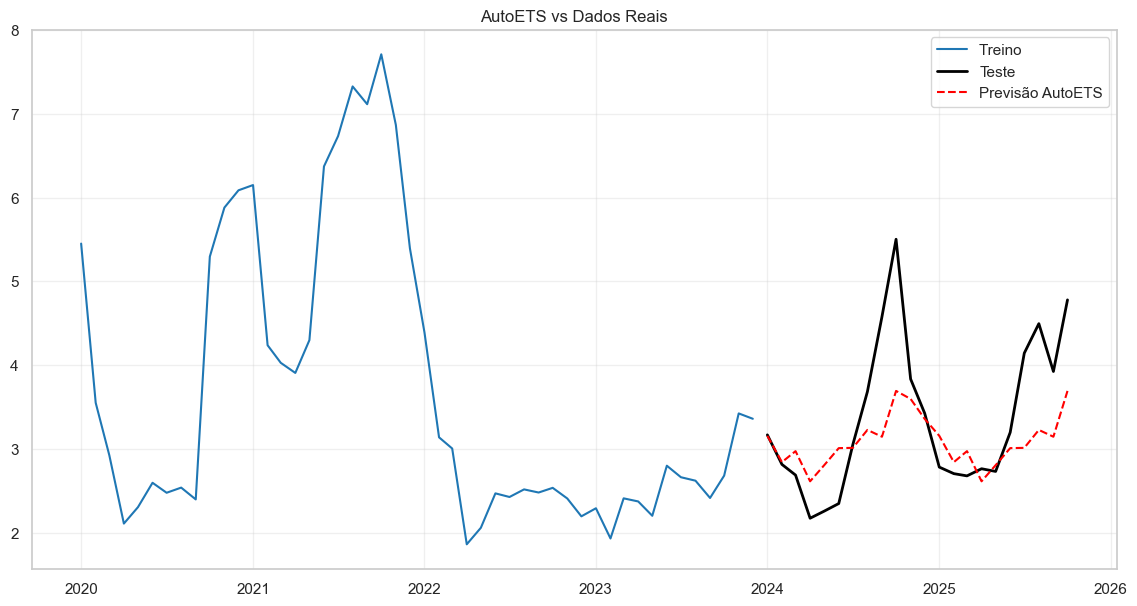

In [14]:
# AutoETS com statsforecast 
# Preparar o formato que o StatsForecast exige (unique_id, ds, y)
df_treino_sf = pd.DataFrame({
    'unique_id': 'co2_eq',
    'ds': treino.index,
    'y': treino.values
})

# Instanciar o AutoETS
# season_length=12 
# ZZZ (Padrão do R) para auto seleção de modelos
sf = StatsForecast(
    models=[AutoETS(model='ZZZ', season_length=12)], 
    freq='MS'
)

# Ajustar o modelo
sf.fit(df_treino_sf)

# Prever
h = len(teste)
previsao_sf = sf.predict(h=h)

# Extrair resultado para plotar
previsao_ets = pd.Series(previsao_sf['AutoETS'].values, index=teste.index)

print("--- Modelo AutoETS Selecionado ---")


# Métricas
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae_ets = mean_absolute_error(teste, previsao_ets)
rmse_ets = np.sqrt(mean_squared_error(teste, previsao_ets))

print(f"MAE: {mae_ets:.4f}")
print(f"RMSE: {rmse_ets:.4f}")


# Pegar o modelo treinado da primeira série (índice 0) e primeiro modelo (índice 0)
modelo_treinado = sf.fitted_[0, 0]

nome_modelo = modelo_treinado.model_['method']

print(f" O AutoETS escolheu o modelo: {nome_modelo}")

# 5. Visualização
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(14, 7))
ax.plot(treino.index[-48:], treino.tail(48), label='Treino ', color='tab:blue')
ax.plot(teste.index, teste, label='Teste', color='black', linewidth=2)
ax.plot(teste.index, previsao_ets, label='Previsão AutoETS', color='red', linestyle='--')
ax.set_title('AutoETS vs Dados Reais')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

MODELO     | AIC          | MAE (Teste)  | RMSE (Teste)
-------------------------------------------------------
A,N,N      | -541.19      | 0.7475       | 0.8836      
A,A,N      | -537.20      | 0.7457       | 0.8758      
A,Ad,N     | -535.21      | 0.7465       | 0.8785      
A,N,A      | -554.23      | 0.5099       | 0.7033      


c:\Users\felipeaasl\Documents\Trabalho_séries_temporais\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\felipeaasl\Documents\Trabalho_séries_temporais\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\felipeaasl\Documents\Trabalho_séries_temporais\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\felipeaasl\Documents\Trabalho_séries_temporais\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\felipeaasl\Document

A,A,A      | -550.23      | 0.4994       | 0.6878      
A,Ad,A     | -548.48      | 0.5085       | 0.7011      
-------------------------------------------------------
 MODELO VENCEDOR (AIC): ETS(A,N,A)
   AIC: -554.23 | MAE: 0.5099


c:\Users\felipeaasl\Documents\Trabalho_séries_temporais\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


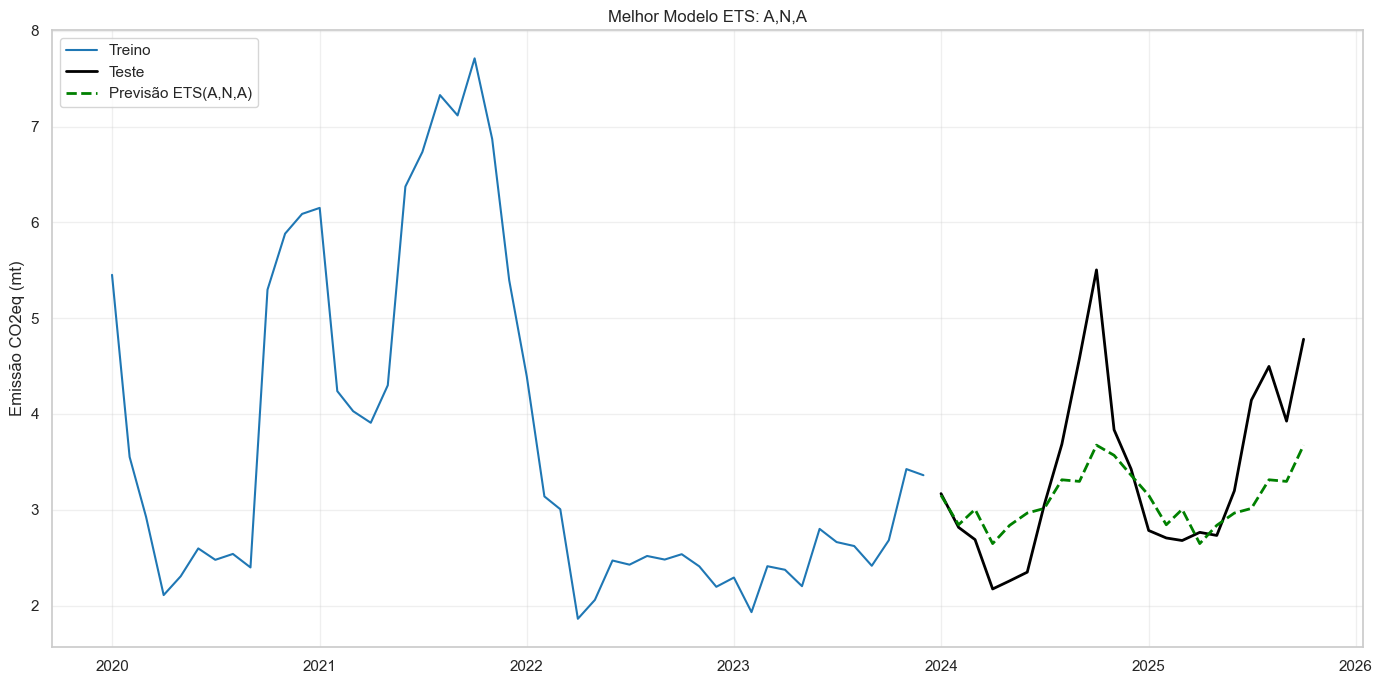


--- RANKING COMPLETO ---
Modelo       AIC    MAE   RMSE
 A,N,A -554.2296 0.5099 0.7033
 A,A,A -550.2333 0.4994 0.6878
A,Ad,A -548.4806 0.5085 0.7011
 A,N,N -541.1939 0.7475 0.8836
 A,A,N -537.2007 0.7457 0.8758
A,Ad,N -535.2114 0.7465 0.8785


In [ ]:
# Auto_ETS com Box-Cox (Guerrero)
# Lista completa de configurações possíveis
# Notação: (Erro, Tendência, Sazonalidade) -> Sempre começa com A pois Box-Cox estabilizou a variância.
configs_ets = [
    # 1. Sem Sazonalidade (Final = N)
    ('A,N,N',        {'trend': None,  'seasonal': None,  'damped_trend': False}), # SES
    ('A,A,N',        {'trend': 'add', 'seasonal': None,  'damped_trend': False}), # Holt Linear
    ('A,Ad,N',       {'trend': 'add', 'seasonal': None,  'damped_trend': True}),  # Holt Amortecido

    # 2. Com Sazonalidade Aditiva (Final = A)
    ('A,N,A',        {'trend': None,  'seasonal': 'add', 'damped_trend': False}), # Sazonal Simples
    ('A,A,A',        {'trend': 'add', 'seasonal': 'add', 'damped_trend': False}), # Holt-Winters
    ('A,Ad,A',       {'trend': 'add', 'seasonal': 'add', 'damped_trend': True}),  # HW Amortecido
]

resultados = []
melhor_aic = float('inf')
vencedor_info = None

print(f"{'MODELO':<10} | {'AIC':<12} | {'MAE (Teste)':<12} | {'RMSE (Teste)':<12}")
print("-" * 55)

for nome, params in configs_ets:
    try:
        # Instanciar e Treinar
        mdl = ExponentialSmoothing(
            treino_guerrero, 
            seasonal_periods=12, 
            trend=params['trend'], 
            seasonal=params['seasonal'],
            damped_trend=params['damped_trend']
        )
        
        # Otimizar parâmetros
        fit = mdl.fit(optimized=True, remove_bias=False)
        
        # Prever 
        pred_guerrero = fit.forecast(len(teste))
        
        # Destransformar (Voltar para CO2eq real)
        pred_real = inv_boxcox(pred_guerrero, lambda_guerrero)
        
        # Calcular métricas
        mae = mean_absolute_error(teste, pred_real)
        rmse = np.sqrt(mean_squared_error(teste, pred_real))
        
        # Guardar resultados
        resultados.append({
            'Modelo': nome, 
            'AIC': fit.aic, 
            'MAE': mae, 
            'RMSE': rmse, 
            'Previsão': pred_real,
            'Params': params
        })
        
        print(f"{nome:<10} | {fit.aic:<12.2f} | {mae:<12.4f} | {rmse:<12.4f}")
        
    except Exception as e:
        print(f"{nome:<10} | Falhou: Convergência não alcançada.")

# Tabela de Classificação
df_resultados = pd.DataFrame(resultados).sort_values(by='AIC')

if not df_resultados.empty:
    vencedor = df_resultados.iloc[0]
    
    print("-" * 55)
    print(f" MODELO VENCEDOR (AIC): ETS({vencedor['Modelo']})")
    print(f"   AIC: {vencedor['AIC']:.2f} | MAE: {vencedor['MAE']:.4f}")

    # Visualização do Modelo Vencedor
    fig, ax = plt.subplots(figsize=(14, 7))

    # Teste
    ax.plot(treino.index[-48:], treino.tail(48), label='Treino', color='tab:blue')
    ax.plot(teste.index, teste, label='Teste', color='black', linewidth=2)

    # Previsão
    pred_series = pd.Series(vencedor['Previsão'].values, index=teste.index)
    ax.plot(teste.index, pred_series, 
            label=f"Previsão ETS({vencedor['Modelo']})", 
            color='green', linestyle='--', linewidth=2)

    ax.set_title(f"Melhor Modelo ETS: {vencedor['Modelo']}")
    ax.set_ylabel('Emissão CO2eq (mt)')
    ax.legend(loc='upper left')
    ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
    
    # Exibir tabela completa ordenada
    print("\n--- RANKING COMPLETO ---")
    print(df_resultados[['Modelo', 'AIC', 'MAE', 'RMSE']].round(4).to_string(index=False))

else:
    print("\n Nenhum modelo funcionou. Verifique os dados.")

                           CLASSIFICAÇÃO FINAL DOS MODELOS                           
                      Modelo    MAE   RMSE  MAPE (%)
SARIMA(2, 0, 0)(0, 1, 1, 12) 0.4475 0.5802   13.1378
                  ETS(A,N,A) 0.5099 0.7033   13.9519
             ETS(ETS(M,N,M)) 0.5228 0.7261   14.1929
    SARIMA(0,1,0)(2,1,1)[12] 0.5602 0.7771   14.8807
SARIMA(1, 1, 0)(1, 0, 1, 12) 0.5670 0.7666   15.5698
SARIMA(2, 1, 2)(0, 1, 1, 12) 0.5705 0.8132   14.6685
                       Naïve 0.7475 0.8836   22.8973
           Média Móvel (12m) 0.8630 1.1768   21.9801
                      SNaïve 0.8851 1.1650   23.4041
-------------------------------------------------------------------------------------
 VENCEDOR: SARIMA(2, 0, 0)(0, 1, 1, 12) (MAE: 0.4475)


C:\Users\felipeaasl\AppData\Local\Temp\ipykernel_1676\3868011777.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cores = cm.get_cmap('tab10', len(df_melhores))


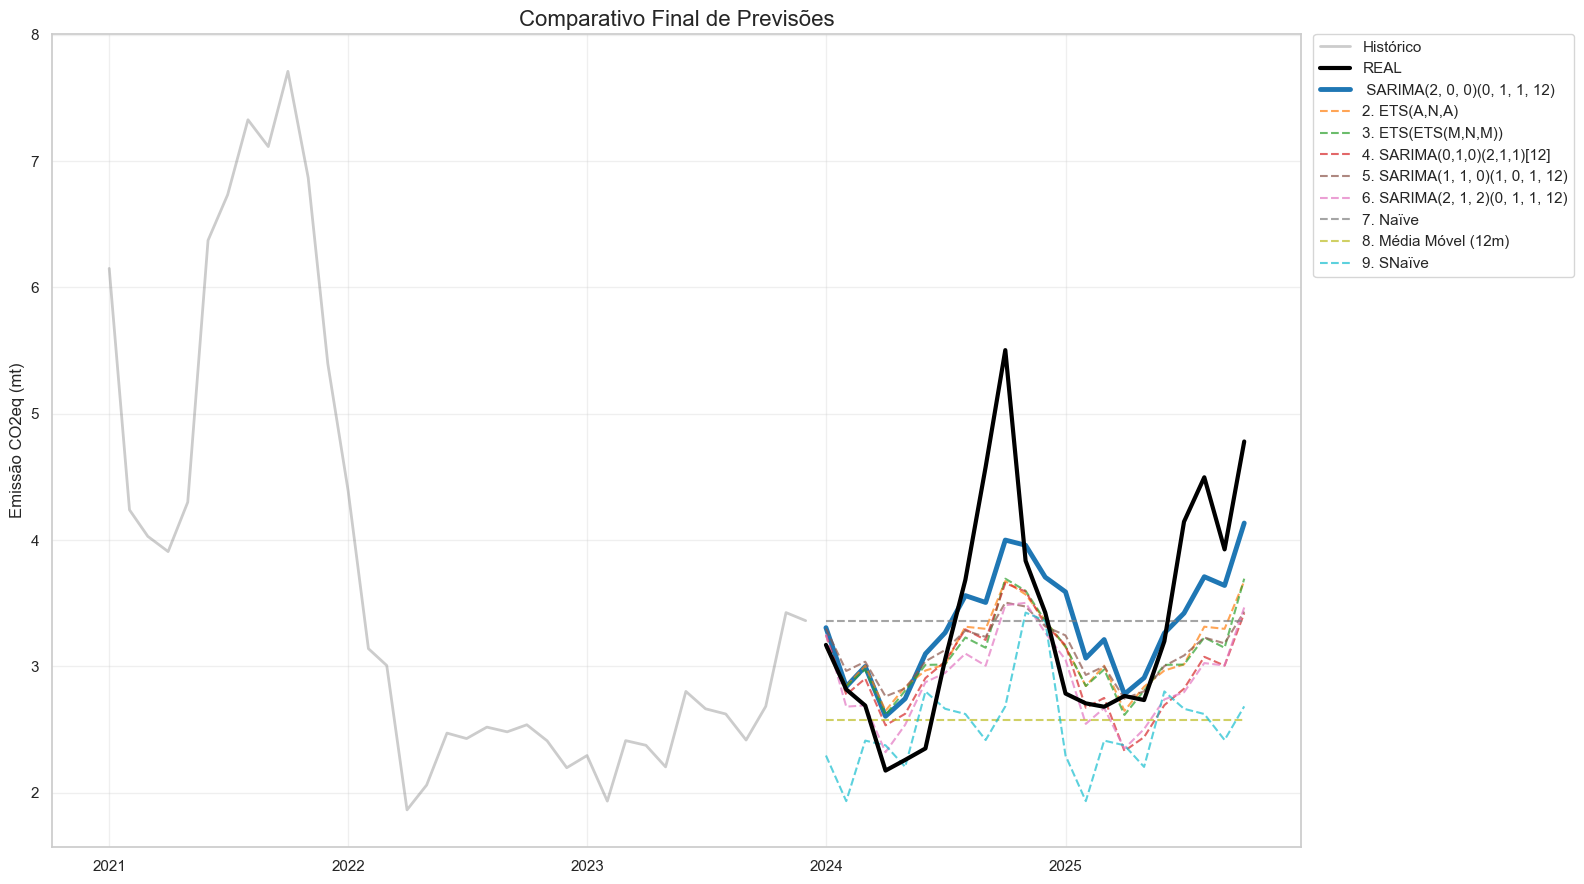

In [16]:
# Resultado dos modelos
#  Benchmarks 
n_test = len(teste)
last_val = treino_guerrero.iloc[-1]
y_pred_naive = np.full(n_test, inv_boxcox(last_val, lambda_guerrero))

last_year = treino_guerrero.iloc[-12:].values
reps = int(np.ceil(n_test / 12))
sna_guerrero = np.tile(last_year, reps)[:n_test]
y_pred_sna = inv_boxcox(sna_guerrero, lambda_guerrero)

media_movel = treino_guerrero.iloc[-12:].mean()
y_pred_ma = np.full(n_test, inv_boxcox(media_movel, lambda_guerrero))

#  Definir Todos os Candidatos
modelos_finais = {
    # Benchmarks
    'Naïve': y_pred_naive,
    'SNaïve': y_pred_sna,
    'Média Móvel (12m)': y_pred_ma,
    
    # O ETS do StatsForecast (Dados Brutos)
    f'ETS({nome_modelo})': previsao_ets, 
    
    # O ETS do Grid Search (Dados Transformados) 
    f"ETS({vencedor['Modelo']})": vencedor['Previsão'],
    
    # SARIMAs
    'SARIMA(0,1,0)(2,1,1)[12]': pred_final_manual,
    f'SARIMA{modelo_auto_d_travado.order}{modelo_auto_d_travado.seasonal_order}': pred_final_auto,
    f'SARIMA{modelo_auto_D_travado.order}{modelo_auto_D_travado.seasonal_order}': pred_final_D,
    f'SARIMA{modelo_auto_dD_travado.order}{modelo_auto_dD_travado.seasonal_order}': pred_final_dD,
}

# Calcular Métricas e Montar Tabela
resultados_gerais = []

for nome, previsao in modelos_finais.items():
    if previsao is None: continue
    try:
        # Padronizar formato (Series ou Array)
        vals = previsao.values if isinstance(previsao, pd.Series) else previsao
        
        mae = mean_absolute_error(teste, vals)
        rmse = np.sqrt(mean_squared_error(teste, vals))
        
        y_true = teste.values
        mape = np.mean(np.abs((y_true - vals) / y_true)) * 100
        
        resultados_gerais.append({'Modelo': nome, 'MAE': mae, 'RMSE': rmse, 'MAPE (%)': mape})
    except Exception as e:
        print(f" Pulo: {nome} (Erro: {e})")

# Tabela Final
df_melhores = pd.DataFrame(resultados_gerais).sort_values(by='MAE').reset_index(drop=True)

print("="*85)
print(f"{'CLASSIFICAÇÃO FINAL DOS MODELOS':^85}")
print("="*85)
print(df_melhores.round(4).to_string(index=False))
print("-" * 85)

campeao = df_melhores.iloc[0]
print(f" VENCEDOR: {campeao['Modelo']} (MAE: {campeao['MAE']:.4f})")

# Gráfico Limpo
fig, ax = plt.subplots(figsize=(16, 9))

# Histórico
ax.plot(treino.index[-36:], treino.tail(36), label='Histórico', color='gray', alpha=0.4, linewidth=2)
ax.plot(teste.index, teste, label='REAL', color='black', linewidth=3, zorder=10)

# Cores Dinâmicas
cores = cm.get_cmap('tab10', len(df_melhores))

for i, row in df_melhores.iterrows():
    nome = row['Modelo']
    previsao = modelos_finais[nome]
    
    # Transformar em Series para plotar com datas
    if not isinstance(previsao, pd.Series):
        previsao = pd.Series(previsao, index=teste.index)
    
    # Estilo
    if i == 0: # Campeão
        estilo = '-'
        lw = 3.5
        alpha = 1.0
        # Legenda apenas com ícone e nome técnico
        label = f" {nome}" 
    else:
        estilo = '--'
        lw = 1.5
        alpha = 0.7
        # Legenda apenas com ranking e nome técnico
        label = f"{i+1}. {nome}"
        
    ax.plot(teste.index, previsao, label=label, color=cores(i), linestyle=estilo, linewidth=lw, alpha=alpha)

ax.set_title('Comparativo Final de Previsões', fontsize=16)
ax.set_ylabel('Emissão CO2eq (mt)')
# Legenda limpa posicionada fora para não poluir
ax.legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0., fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show() 

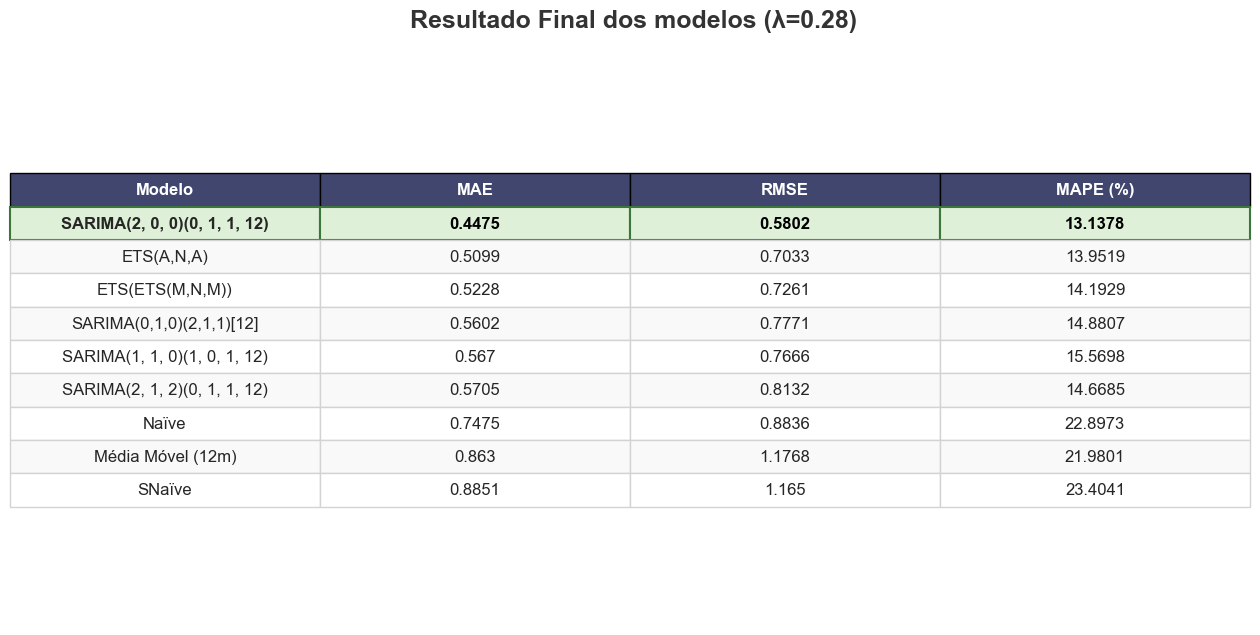

In [17]:
# Vizualização dos modelos
# cópia para arredondar apenas para visualização
df_display = df_melhores.copy()

# Arredondar colunas numéricas para 4 casas
cols_num = ['MAE', 'RMSE', 'MAPE (%)']
df_display[cols_num] = df_display[cols_num].round(4)

# Configurar a Figura
altura_fig = max(6, len(df_display) * 0.6 + 2)
fig, ax = plt.subplots(figsize=(16, altura_fig)) 

# Esconder eixos
ax.axis('off')
ax.axis('tight')

# Cores e Estilo
cor_cabecalho = '#40466e'      # Azul escuro profissional
cor_vencedor = '#dff0d8'       # Verde claro
cor_linhas_pares = '#f9f9f9'   # Cinza bem claro
cor_linhas_impares = '#ffffff' # Branco
cor_fonte_cabecalho = 'white'
cor_melhor_metrica = '#ffeec2' 

# Criar a Tabela
tabela = ax.table(cellText=df_display.values,
                  colLabels=df_display.columns,
                  loc='center',
                  cellLoc='center')

# Ajustes de Fonte e Escala
tabela.auto_set_font_size(False)
tabela.set_fontsize(12)
tabela.scale(1.0, 2.0)

# Iterar sobre as células para aplicar estilos
for (row, col), cell in tabela.get_celld().items():
    
    # Cabeçalho
    if row == 0:
        cell.set_text_props(weight='bold', color=cor_fonte_cabecalho)
        cell.set_facecolor(cor_cabecalho)
        cell.set_edgecolor('black')
    
    # Dados
    else:
        
        if row % 2 == 0:
            cell.set_facecolor(cor_linhas_pares)
        else:
            cell.set_facecolor(cor_linhas_impares)
            
        cell.set_edgecolor('lightgrey')
        
        # Destaque para o Vencedor
        # Como df_display já está ordenado por MAE, a linha 1 é o vencedor
        if row == 1:
            cell.set_facecolor(cor_vencedor)
            cell.set_text_props(weight='bold')
            # Borda mais grossa para o campeão
            cell.set_linewidth(1.5) 
            cell.set_edgecolor('#3c763d') 

# Destacar a melhor métrica em cada coluna individualmente
# Mesmo que o vencedor do MAE ganhe, às vezes outro modelo tem melhor RMSE ou MAPE
# +1 no índice por causa do cabeçalho
idx_min_mae = df_display['MAE'].idxmin() + 1
idx_min_rmse = df_display['RMSE'].idxmin() + 1
idx_min_mape = df_display['MAPE (%)'].idxmin() + 1

# Colunas: 0=Modelo, 1=MAE, 2=RMSE, 3=MAPE
tabela[(idx_min_mae, 1)].set_text_props(weight='bold', color='black')
tabela[(idx_min_rmse, 2)].set_text_props(weight='bold', color='black')
tabela[(idx_min_mape, 3)].set_text_props(weight='bold', color='black')

# Título e Salvamento
plt.title(f' Resultado Final dos modelos (λ=0.28)', 
          fontsize=18, weight='bold', pad=20, color='#333333')

plt.show()


--- Treinando Modelo Final ---
Período: 2008-01-01 até 2025-10-01
Total de observações: 214
Aplicando transformação Box-Cox com λ = 0.2786

Resumo do Modelo Final:
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  214
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                   5.687
Date:                              Mon, 24 Nov 2025   AIC                             -1.374
Time:                                      13:09:07   BIC                             15.167
Sample:                                  01-01-2008   HQIC                             5.318
                                       - 10-01-2025                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------

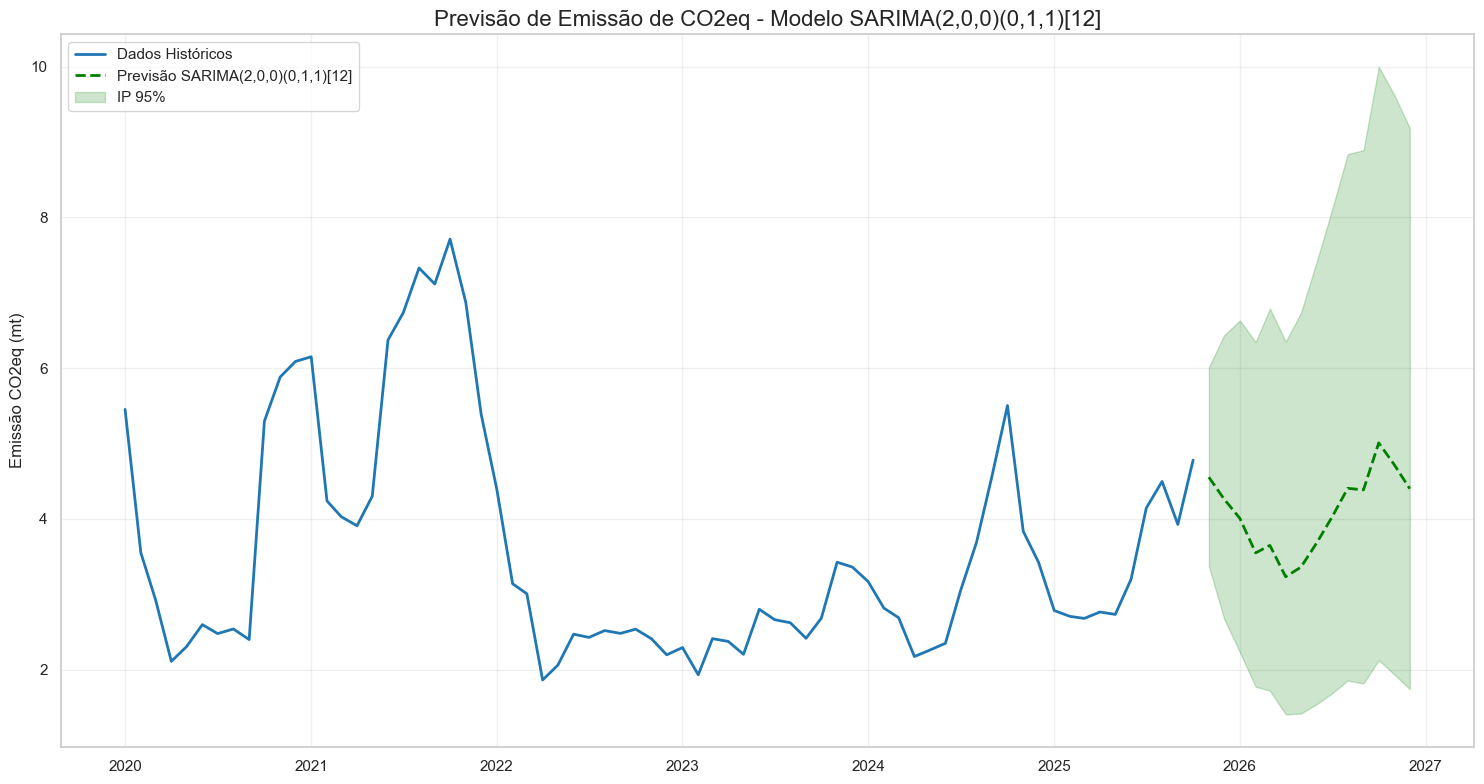

In [18]:

# Previsão modelo vencedor final
# Modelo: SARIMA(2,0,0)(0,1,1)[12]


# Preparação da Série Completa (União de Treino + Teste)
# O df_focado já contém todo o histórico desde 2008 até o último dado de 2025.
serie_completa = df_focado.set_index('data')['co2_mt']

print(f"--- Treinando Modelo Final ---")
print(f"Período: {serie_completa.index.min().date()} até {serie_completa.index.max().date()}")
print(f"Total de observações: {len(serie_completa)}")

# Transformação Box-Cox na Série Completa
# Aplicar o lambda_guerrero em toda a série agora.
print(f"Aplicando transformação Box-Cox com λ = {lambda_guerrero:.4f}")

serie_completa_boxcox = pd.Series(
    stats.boxcox(serie_completa, lmbda=lambda_guerrero),
    index=serie_completa.index
)

# Treinamento 
modelo_final = pm.ARIMA(
    order=(2, 0, 0),              # Parâmetros do Vencedor (p,d,q)
    seasonal_order=(0, 1, 1, 12), # Parâmetros do Vencedor (P,D,Q,m)
    suppress_warnings=True
)

modelo_final.fit(serie_completa_boxcox)

print("\nResumo do Modelo Final:")
print(modelo_final.summary())

# Previsão para o Futuro (Nov/2025 a Dez/2026)
n_previsao = 14
pred_boxcox, conf_int_boxcox = modelo_final.predict(
    n_periods=n_previsao, 
    return_conf_int=True,
    alpha=0.05
)

# Reverter a Transformação (Voltar para CO2eq real)
pred_real = inv_boxcox(pred_boxcox, lambda_guerrero)
conf_int_real = inv_boxcox(conf_int_boxcox, lambda_guerrero)

# Criar DataFrame com as datas futuras
datas_futuras = pd.date_range(
    start=serie_completa.index.max() + pd.DateOffset(months=1),
    periods=n_previsao,
    freq='MS'
)

df_futuro = pd.DataFrame({
    'Previsão (CO2eq)': pred_real.values,
    'Limite Inferior': conf_int_real[:, 0],
    'Limite Superior': conf_int_real[:, 1]
}, index=datas_futuras)

print("\n--- Projeção (2025-2026) ---")
print(df_futuro.round(4))

# Visualização Final
fig, ax = plt.subplots(figsize=(15, 8))

# Plotar histórico recente 
# Plot série sem transformação
ax.plot(serie_completa['2020':], label='Dados Históricos', color='tab:blue', linewidth=2)

# Plotar Previsão
ax.plot(df_futuro.index, df_futuro['Previsão (CO2eq)'], 
        label='Previsão SARIMA(2,0,0)(0,1,1)[12]', 
        color='green', linestyle='--', linewidth=2)

# Intervalo de Previsão
ax.fill_between(
    df_futuro.index, 
    df_futuro['Limite Inferior'], 
    df_futuro['Limite Superior'], 
    color='green', alpha=0.2, label='IP 95%'
)

ax.set_title('Previsão de Emissão de CO2eq - Modelo SARIMA(2,0,0)(0,1,1)[12]', fontsize=16)
ax.set_ylabel('Emissão CO2eq (mt)')
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()